# Workload Characterization

## Introduction

### Import relevant modules

In [1]:
# Data Analysis
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing

# Utilities
import numpy as np
# from tqdm import tnrange
import pickle
import os
from tqdm import tqdm_notebook as tqdmn
# import warnings

In [2]:
%config InlineBackend.figure_format = 'retina'

# High level parameters

## Read data

In [3]:
df_high = pd.read_csv('WC_report_client.csv')
df_high.head()

,timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,sentBytes,grpThreads,allThreads,URL,Latency,IdleTime,Connect
0,1610622816777,98,HTTP Request - Repubblica Home,200,OK,Thread Group - Slow Low 2-1,text,True,NaN,1968024,135,1,4,http://192.168.56.101/RepubblicaHome.html,49,0,34
1,1610622816777,114,HTTP Request - Repubblica Home,200,OK,Thread Group - Slow High 1-1,text,True,NaN,1968024,135,1,4,http://192.168.56.101/RepubblicaHome.html,49,0,34
2,1610622816777,124,HTTP Request - YouTube Home,200,OK,Thread Group - Fast Low 4-1,text,True,NaN,4159636,132,1,4,http://192.168.56.101/YouTubeHome.html,49,0,34
3,1610622816777,128,HTTP Request - YouTube Home,200,OK,Thread Group - Fast High 3-1,text,True,NaN,4159636,132,1,4,http://192.168.56.101/YouTubeHome.html,49,0,34
4,1610622817197,28,HTTP Request - Wikipedia Home,200,OK,Thread Group - Fast Low 4-2,text,True,NaN,71559,134,2,8,http://192.168.56.101/WikipediaHome.html,25,0,3


In [4]:
print('The dataset contains', df_high.shape[1], 'columns and', df_high.shape[0], 'rows')

The dataset contains 17 columns and 4464 rows


In [5]:
df_high['success'].all()

True

In [6]:
df_high.loc[df_high['threadName'].str.contains('Slow'), 'throughputType'] = 'slow'
df_high.loc[df_high['threadName'].str.contains('Fast'), 'throughputType'] = 'fast'

df_high.loc[df_high['threadName'].str.contains('Low'), 'usersType'] = 'low'
df_high.loc[df_high['threadName'].str.contains('High'), 'usersType'] = 'high'

df_high.loc[df_high['label'].str.contains('Wikipedia'), 'resourceType'] = 'small'
df_high.loc[df_high['label'].str.contains('Repubblica'), 'resourceType'] = 'medium'
df_high.loc[df_high['label'].str.contains('YouTube'), 'resourceType'] = 'large'

df_high.loc[:, 'requestType'] = df_high.loc[:, 'throughputType'] + ' - ' + df_high.loc[:, 'usersType']  + ' - ' + df_high.loc[:, 'resourceType']

df_high.head()

,timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,...,grpThreads,allThreads,URL,Latency,IdleTime,Connect,throughputType,usersType,resourceType,requestType
0,1610622816777,98,HTTP Request - Repubblica Home,200,OK,Thread Group - Slow Low 2-1,text,True,NaN,1968024,...,1,4,http://192.168.56.101/RepubblicaHome.html,49,0,34,slow,low,medium,slow - low - medium
1,1610622816777,114,HTTP Request - Repubblica Home,200,OK,Thread Group - Slow High 1-1,text,True,NaN,1968024,...,1,4,http://192.168.56.101/RepubblicaHome.html,49,0,34,slow,high,medium,slow - high - medium
2,1610622816777,124,HTTP Request - YouTube Home,200,OK,Thread Group - Fast Low 4-1,text,True,NaN,4159636,...,1,4,http://192.168.56.101/YouTubeHome.html,49,0,34,fast,low,large,fast - low - large
3,1610622816777,128,HTTP Request - YouTube Home,200,OK,Thread Group - Fast High 3-1,text,True,NaN,4159636,...,1,4,http://192.168.56.101/YouTubeHome.html,49,0,34,fast,high,large,fast - high - large
4,1610622817197,28,HTTP Request - Wikipedia Home,200,OK,Thread Group - Fast Low 4-2,text,True,NaN,71559,...,2,8,http://192.168.56.101/WikipediaHome.html,25,0,3,fast,low,small,fast - low - small


## Data analysis

In [7]:
df_high.describe()

,timeStamp,elapsed,responseCode,failureMessage,bytes,sentBytes,grpThreads,allThreads,Latency,IdleTime,Connect
count,4.464000e+03,4464.000000,4464.0,0.0,4.464000e+03,4464.000000,4464.000000,4464.000000,4464.000000,4464.0,4464.000000
mean,1.610623e+12,40.611335,200.0,NaN,2.032144e+06,133.659050,16.403674,59.028450,5.962814,0.0,0.637993
std,8.593761e+04,37.158805,0.0,NaN,1.739132e+06,1.250863,4.912831,5.691237,8.246997,0.0,1.645545
min,1.610623e+12,1.000000,200.0,NaN,7.155800e+04,132.000000,1.000000,1.000000,0.000000,0.0,0.000000
25%,1.610623e+12,10.000000,200.0,NaN,1.586220e+05,132.000000,10.000000,60.000000,2.000000,0.0,0.000000
50%,1.610623e+12,28.000000,200.0,NaN,1.542999e+06,134.000000,20.000000,60.000000,3.000000,0.0,0.000000
75%,1.610623e+12,63.000000,200.0,NaN,4.061363e+06,135.000000,20.000000,60.000000,6.000000,0.0,1.000000
max,1.610623e+12,195.000000,200.0,NaN,5.096468e+06,135.000000,20.000000,60.000000,114.000000,0.0,34.000000


In [8]:
# fig = plt.figure(figsize=(12,6))

# ax0 = fig.add_subplot(1,2,1)
# ax1 = fig.add_subplot(1,2,2)

# df_high.elapsed.plot.hist(bins=50, ax=ax0)
# df_high.elapsed.plot.hist(bins=50, ax=ax1)

# ax0.set_title('Elapsed')
# ax0.set_xlabel('Time (ms)')

# ax1.set_title('Elapsed')
# ax1.set_ylabel('log(Frequency)')
# ax1.set_xlabel('Time (ms)')
# ax1.set_yscale('log', nonpositive='clip')

# plt.show()

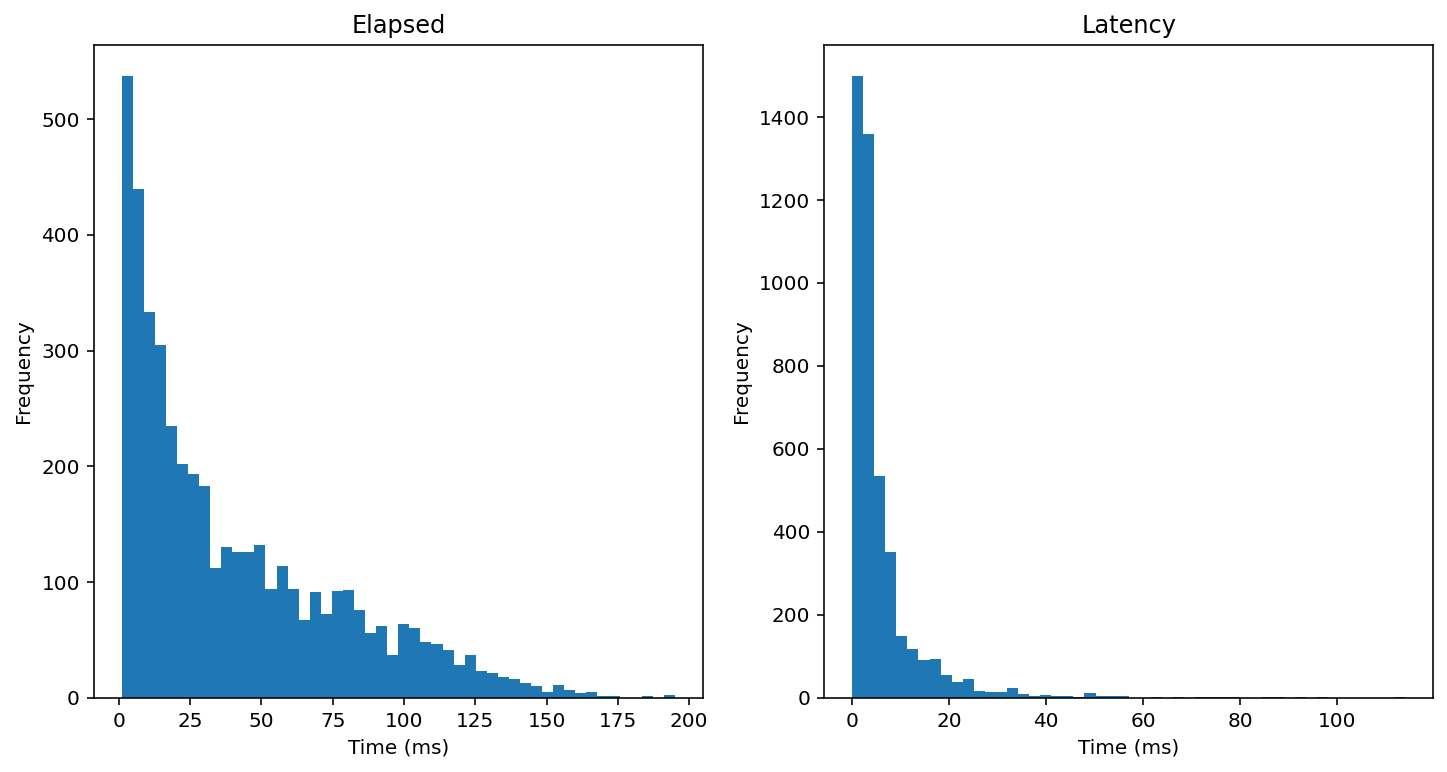

In [9]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.elapsed.plot.hist(bins=50, ax=ax0)
df_high.Latency.plot.hist(bins=50, ax=ax1)

ax0.set_title('Elapsed')
ax0.set_xlabel('Time (ms)')

ax1.set_title('Latency')
ax1.set_xlabel('Time (ms)')
fig.savefig("./images/Esercizio3_WC_HL_Elapsed_Latency.svg", format = "svg")
plt.show()

In [10]:
# fig = plt.figure(figsize=(12,6))

# ax0 = fig.add_subplot(1,2,1)
# ax1 = fig.add_subplot(1,2,2)

# df_high.Latency.plot.hist(bins=50, ax=ax0)
# df_high.Latency.plot.hist(bins=50, ax=ax1)

# ax0.set_title('Latency')
# ax0.set_xlabel('Time (ms)')

# ax1.set_title('Latency')
# ax1.set_ylabel('log(Frequency)')
# ax1.set_xlabel('Time (ms)')
# ax1.set_yscale('log', nonpositive='clip')

# plt.show()

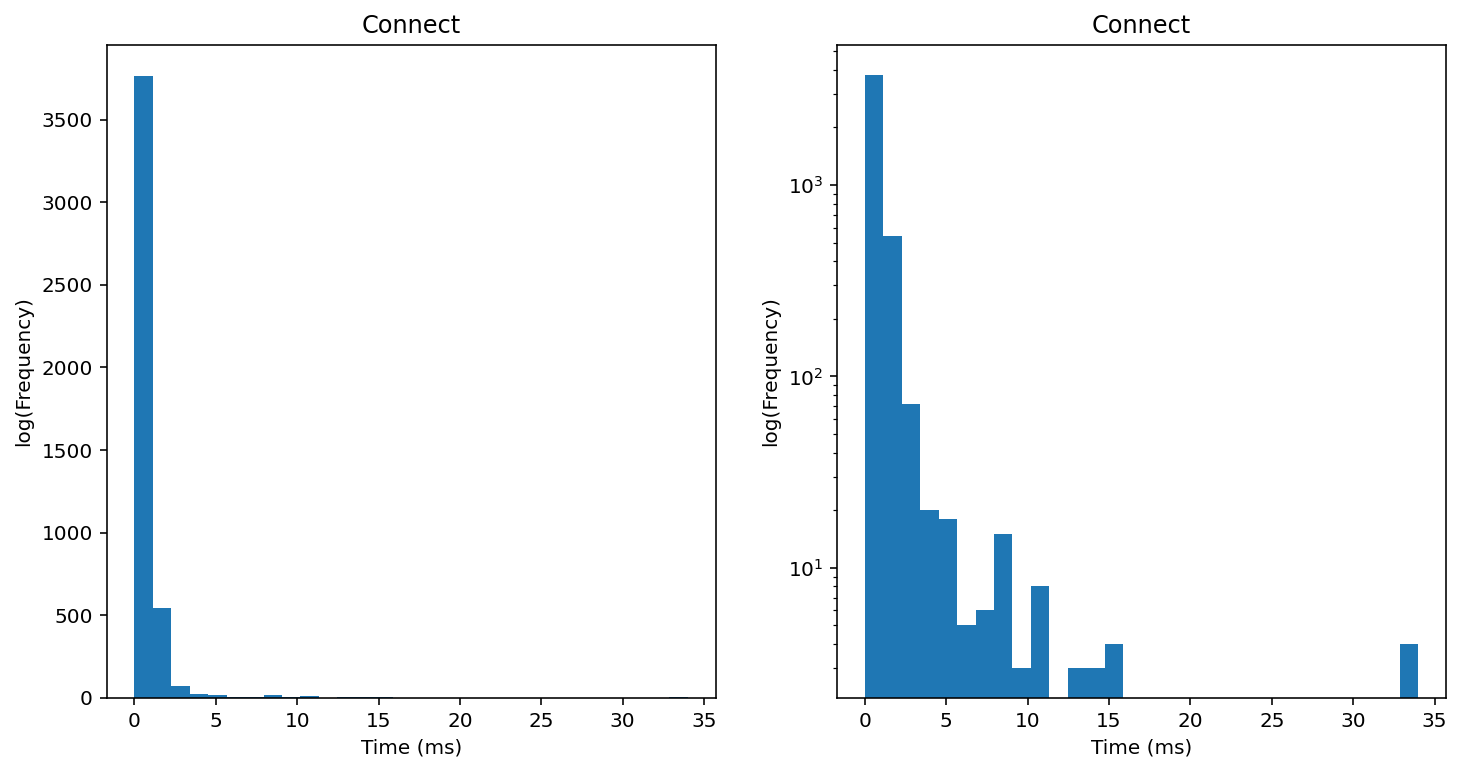

In [11]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.Connect.plot.hist(bins=30, ax=ax0)
df_high.Connect.plot.hist(bins=30, ax=ax1)

ax0.set_title('Connect')
ax0.set_ylabel('log(Frequency)')
ax0.set_xlabel('Time (ms)')

ax1.set_title('Connect')
ax1.set_ylabel('log(Frequency)')
ax1.set_xlabel('Time (ms)')
ax1.set_yscale('log', nonpositive='clip')

plt.savefig("./images/Esercizio3_WC_HL_Connect.svg", format = "svg")

plt.show()

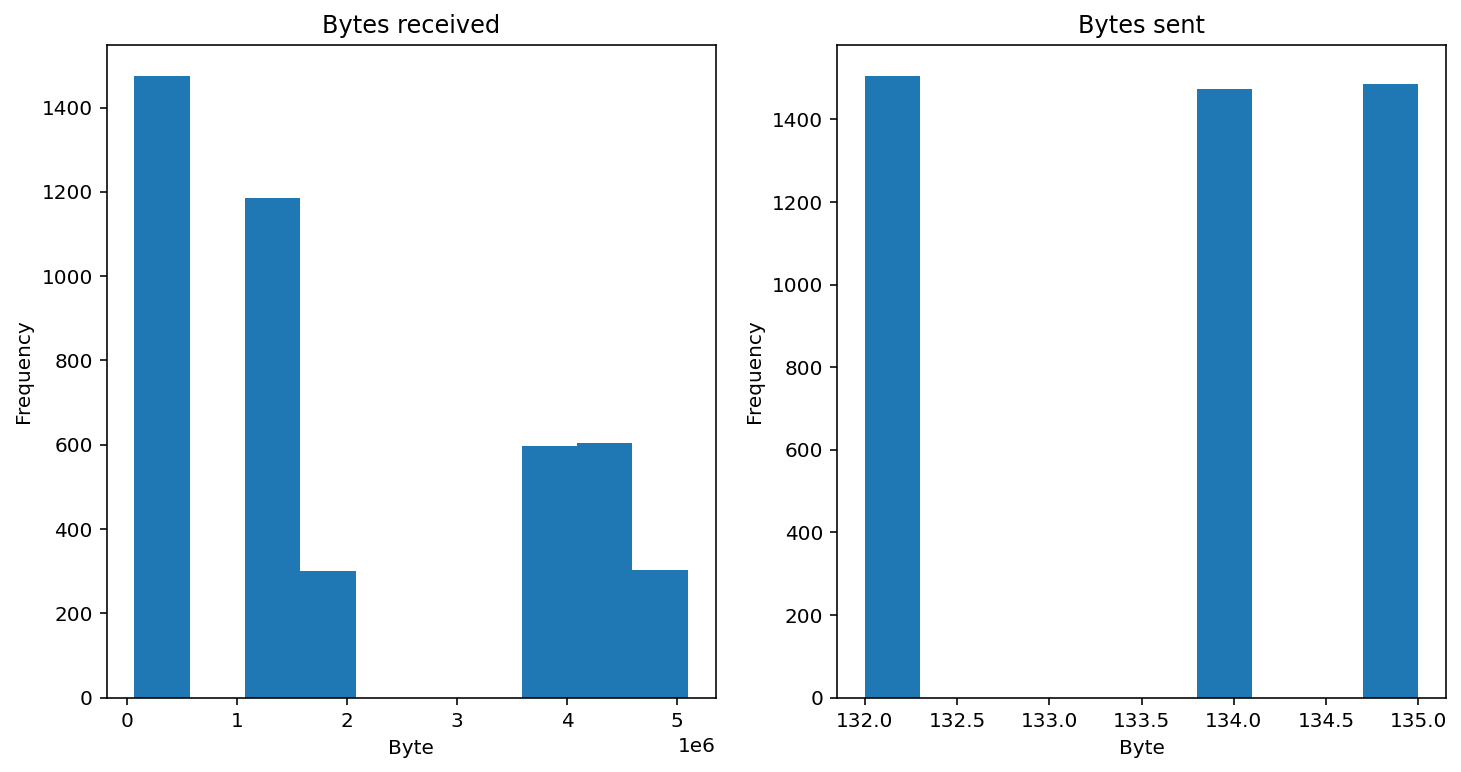

In [12]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.bytes.plot.hist(ax=ax0)
df_high.sentBytes.plot.hist(ax=ax1)

ax0.set_title('Bytes received')
ax0.set_xlabel('Byte')

ax1.set_title('Bytes sent')
ax1.set_xlabel('Byte')
plt.savefig("./images/Esercizio3_WC_HL_Bytes.svg", format = "svg")

plt.show()

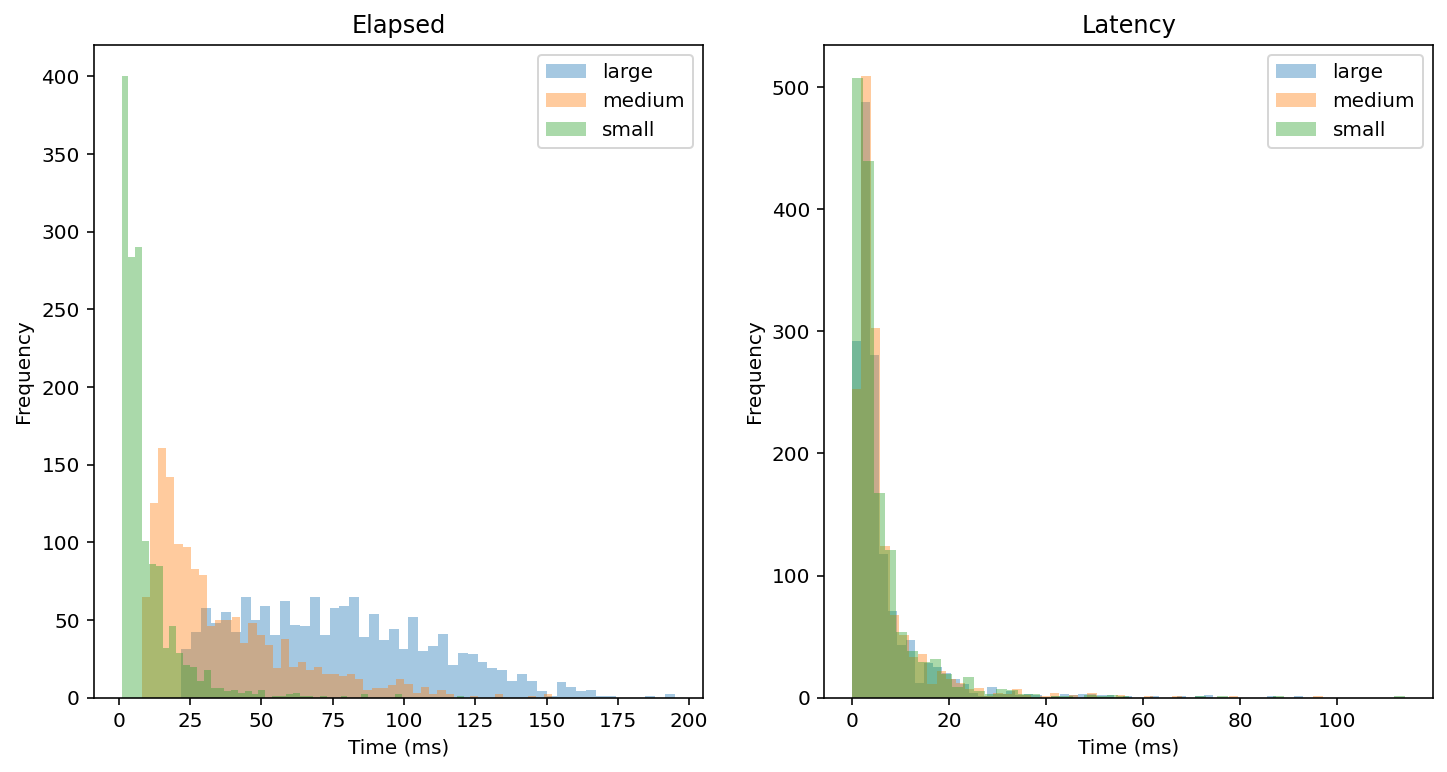

In [13]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.groupby(by='resourceType').elapsed.plot.hist(bins=50, alpha=0.4, legend=True, ax=ax0)
df_high.groupby(by='resourceType').Latency.plot.hist(bins=50, alpha=0.4, legend=True, ax=ax1)

# x_max = df_high.quantile(q=0.99).elapsed
# ax0.set_xlim(-5,x_max)
ax0.set_title('Elapsed')
ax0.set_xlabel('Time (ms)')

# x_max = df_high.quantile(q=0.99).Latency
# ax1.set_xlim(-1,x_max)
ax1.set_title('Latency')
ax1.set_xlabel('Time (ms)')


fig.savefig("./images/Esercizio3_WC_HL_Elapsed_Latency_Type.svg", format = "svg")

plt.show()

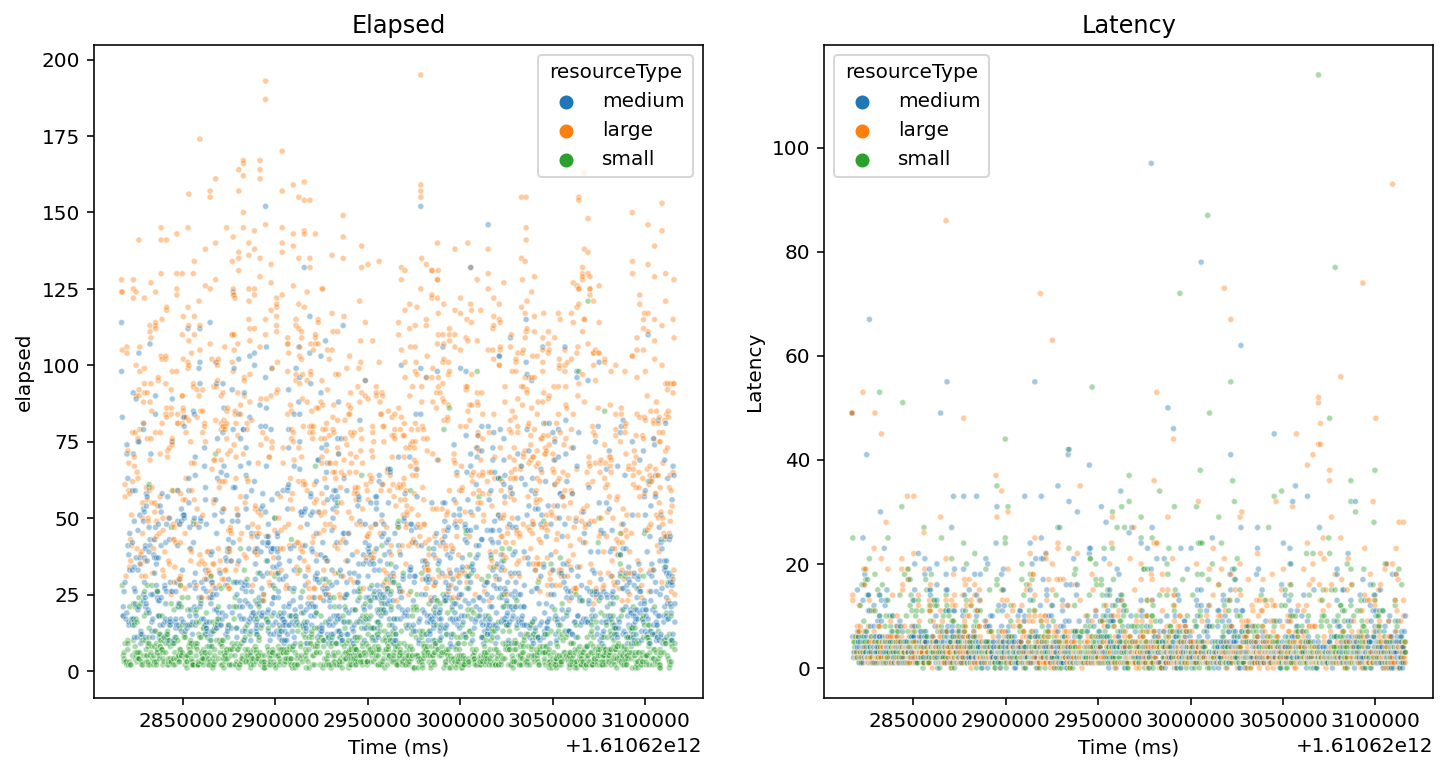

In [14]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

sns.scatterplot(x='timeStamp', y='elapsed', hue='resourceType', data=df_high, marker='.', alpha=.4, ax=ax0)
sns.scatterplot(x='timeStamp', y='Latency', hue='resourceType', data=df_high, marker='.', alpha=.4, ax=ax1)

ax0.set_title('Elapsed')
ax0.set_xlabel('Time (ms)')

ax1.set_title('Latency')
ax1.set_xlabel('Time (ms)')
fig.savefig("./images/Esercizio3_WC_HL_Scatter_Elapsed_Latency.svg", format = "svg")
plt.show()

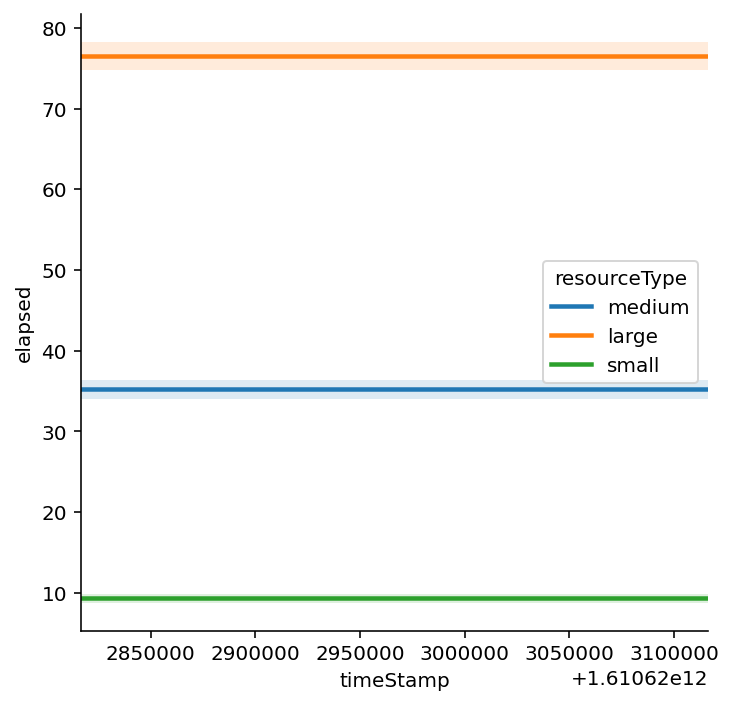

In [15]:
sns.lmplot(x='timeStamp', y='elapsed', hue='resourceType', data=df_high, markers='.', legend_out=False, scatter=False, height=5).savefig("./images/Esercizio3_WC_HL_lmplot_Elapsed.svg", format = "svg")
plt.show()

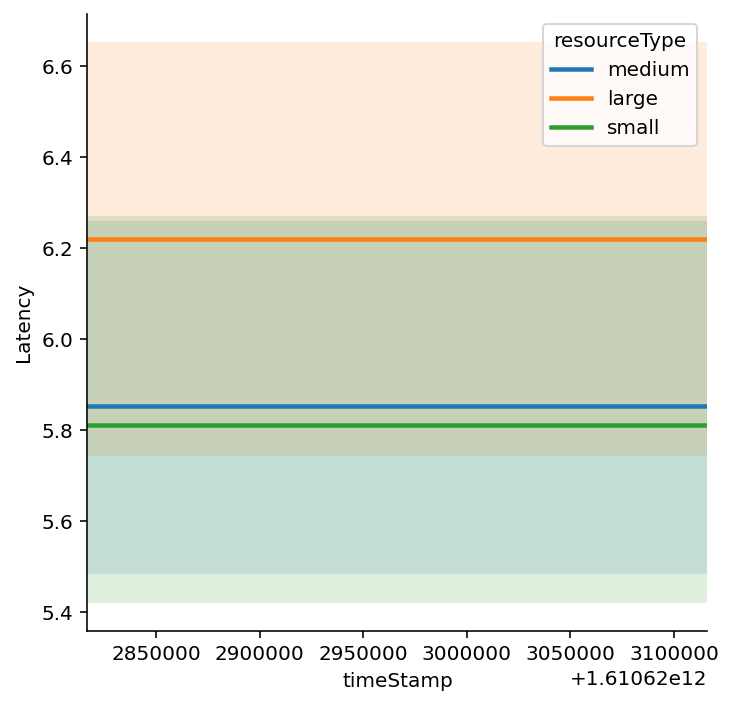

In [16]:
sns.lmplot(x='timeStamp', y='Latency', hue='resourceType', data=df_high, markers='.', legend_out=False, scatter=False, height=5).savefig("./images/Esercizio3_WC_HL_lmplot_Latency.svg", format = "svg")
plt.show()

### Outlier analysis

In [17]:
q = df_high.quantile(q=0.99)
q

timeStamp         1.610623e+12
elapsed           1.450000e+02
responseCode      2.000000e+02
success           1.000000e+00
failureMessage             NaN
bytes             5.096468e+06
sentBytes         1.350000e+02
grpThreads        2.000000e+01
allThreads        6.000000e+01
Latency           4.300000e+01
IdleTime          0.000000e+00
Connect           7.000000e+00
Name: 0.99, dtype: float64

In [18]:
# df_no_outlier = df_high.loc[(df_high['elapsed']<=q['elapsed']) & (df_high['Latency']<=q['Latency']) & (df_high['Connect']<=q['Connect'])]
# df_no_outlier.shape

In [19]:
df_no_outlier = df_high.copy()

## PCA

### Preprocessing

#### Remove nominal columns

In [20]:
# df_high_pre = df_high.select_dtypes(include=['int64']).copy().drop(columns=['timeStamp', 'grpThreads', 'allThreads', 'Connect', 'Latency'])
# df_high_pre = df_no_outlier.select_dtypes(include=['int64']).copy().drop(columns=['timeStamp', 'grpThreads', 'allThreads'])
df_high_pre = df_no_outlier.select_dtypes(include=['int64']).copy().drop(columns=['timeStamp'])

df_high_pre.head()

,elapsed,responseCode,bytes,sentBytes,grpThreads,allThreads,Latency,IdleTime,Connect
0,98,200,1968024,135,1,4,49,0,34
1,114,200,1968024,135,1,4,49,0,34
2,124,200,4159636,132,1,4,49,0,34
3,128,200,4159636,132,1,4,49,0,34
4,28,200,71559,134,2,8,25,0,3


In [21]:
# request_type_encoder = preprocessing.LabelEncoder()
# request_type_encoder.fit(df_high['requestType'].unique())

# df_high_pre['requestType'] = request_type_encoder.transform(df_no_outlier['requestType'])

# df_high_pre.head()

#### Remove constant components

In [22]:
df_const = df_high_pre.loc[:,df_high_pre.columns[df_high_pre.nunique() == 1]]
df_const.head()

,responseCode,IdleTime
0,200,0
1,200,0
2,200,0
3,200,0
4,200,0


In [23]:
df_high_pre = df_high_pre.loc[:,df_high_pre.columns[df_high_pre.nunique() != 1]]
df_high_pre.head()

,elapsed,bytes,sentBytes,grpThreads,allThreads,Latency,Connect
0,98,1968024,135,1,4,49,34
1,114,1968024,135,1,4,49,34
2,124,4159636,132,1,4,49,34
3,128,4159636,132,1,4,49,34
4,28,71559,134,2,8,25,3


#### Remove perfectly correlated components

In [24]:
df_corr = df_high_pre.corr()
df_corr

,elapsed,bytes,sentBytes,grpThreads,allThreads,Latency,Connect
elapsed,1.000000,0.752002,-0.559024,-0.046164,-0.021211,0.291623,0.098535
bytes,0.752002,1.000000,-0.762517,0.006186,-0.017640,0.020631,0.001038
sentBytes,-0.559024,-0.762517,1.000000,0.030678,-0.000998,-0.020365,0.007949
grpThreads,-0.046164,0.006186,0.030678,1.000000,0.312461,-0.089673,-0.088737
allThreads,-0.021211,-0.017640,-0.000998,0.312461,1.000000,-0.044241,-0.202384
Latency,0.291623,0.020631,-0.020365,-0.089673,-0.044241,1.000000,0.150577
Connect,0.098535,0.001038,0.007949,-0.088737,-0.202384,0.150577,1.000000


#### Normalize the components

In [25]:
x = df_high_pre.values

x_scaled = StandardScaler().fit_transform(x)

df_high_pre = pd.DataFrame(data=x_scaled, columns=df_high_pre.columns)
df_high_pre.head()

,elapsed,bytes,sentBytes,grpThreads,allThreads,Latency,Connect
0,1.544589,-0.036873,1.072139,-3.135748,-9.670061,5.219113,20.276407
1,1.975222,-0.036873,1.072139,-3.135748,-9.670061,5.219113,20.276407
2,2.244367,1.223443,-1.326473,-3.135748,-9.670061,5.219113,20.276407
3,2.352025,1.223443,-1.326473,-3.135748,-9.670061,5.219113,20.276407
4,-0.339428,-1.127462,0.272602,-2.932176,-8.967148,2.308637,1.435556


### Perform PCA

In [26]:
pca = PCA()

princ_comp = pca.fit(df_high_pre.values)

In [27]:
d = pca.transform(df_high_pre.values)

c = [str(s) for s in range(princ_comp.n_components_)]
c = ['comp ' + s for s in c]

df_high_pca = pd.DataFrame(data=d, columns=c)
df_high_pca.head()

,comp 0,comp 1,comp 2,comp 3,comp 4,comp 5,comp 6
0,2.779448,18.814387,5.952517,12.082975,-1.048802,-0.604398,-0.805562
1,3.023143,18.827577,6.024479,12.054973,-1.035627,-0.331973,-0.592181
2,5.233477,18.380816,5.442741,12.269865,-1.157360,-1.720147,-0.541548
3,5.294401,18.384113,5.460732,12.262865,-1.154066,-1.652041,-0.488202
4,-0.096282,8.478738,-2.192427,-0.399054,4.486821,-0.843899,0.388234


#### Explained variance

In [28]:
d = {'explained variance': princ_comp.explained_variance_, 'explained variance ratio': princ_comp.explained_variance_ratio_}

df_variance_PCA = pd.DataFrame(data=d)

df_variance_PCA['cumulative explained variance ratio'] = df_variance_PCA.cumsum()['explained variance ratio']
df_variance_PCA.head(10)

,explained variance,explained variance ratio,cumulative explained variance ratio
0,2.420032,0.345641,0.345641
1,1.468367,0.209720,0.555361
2,1.054832,0.150656,0.706018
3,0.873071,0.124697,0.830714
4,0.651551,0.093058,0.923772
5,0.381743,0.054523,0.978295
6,0.151971,0.021705,1.000000


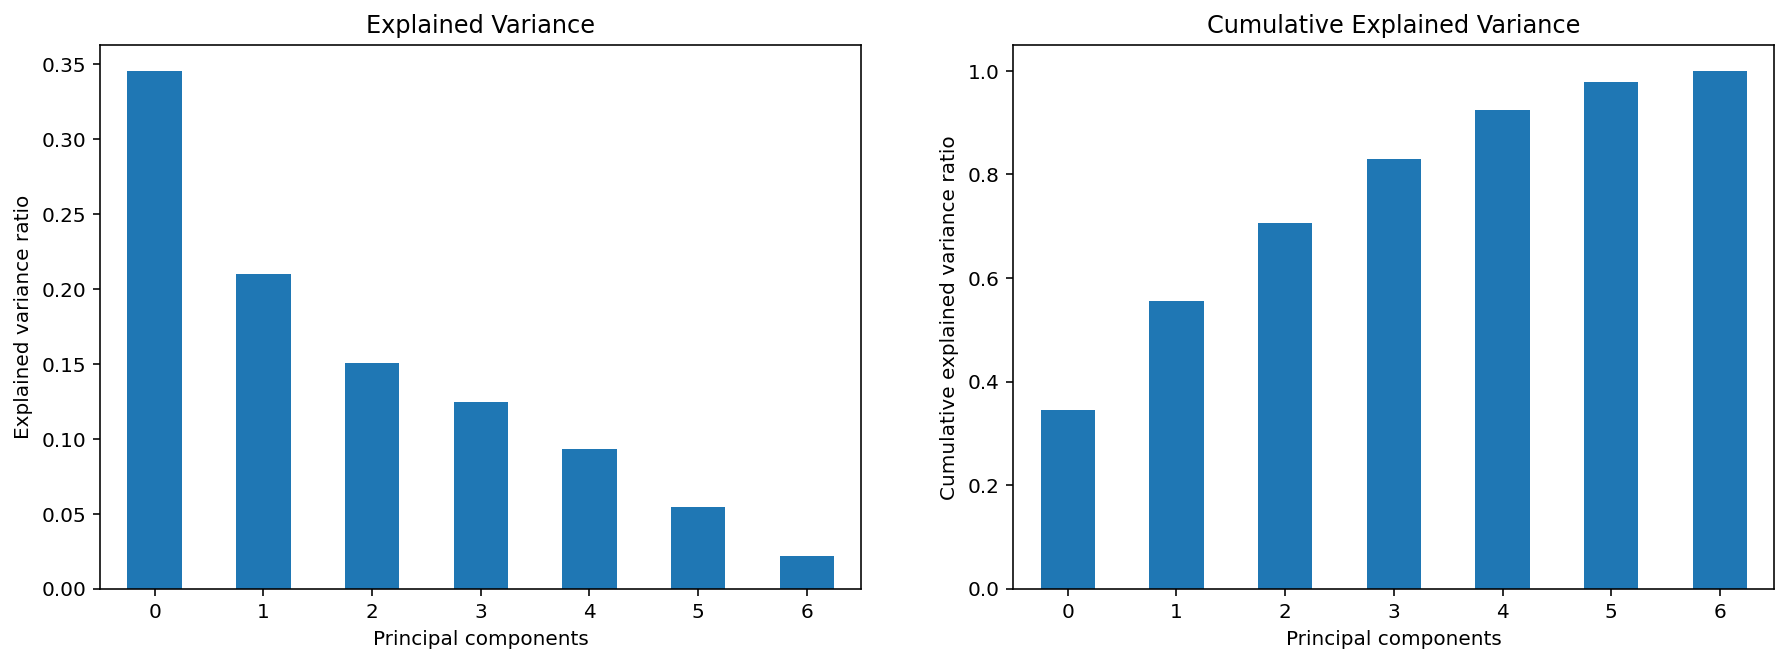

In [29]:
fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

df_variance_PCA.plot.bar(y=['explained variance ratio'], ax=ax0, legend=False)
df_variance_PCA.plot.bar(y=['cumulative explained variance ratio'], ax=ax1, legend=False)

ax0.tick_params(labelrotation=0)
ax0.set_title('Explained Variance')
ax0.set_xlabel('Principal components')
ax0.set_ylabel('Explained variance ratio')

ax1.tick_params(labelrotation=0)
ax1.set_title('Cumulative Explained Variance')
ax1.set_xlabel('Principal components')
ax1.set_ylabel('Cumulative explained variance ratio')
fig.savefig("./images/Esercizio3_WC_HL_PCA.svg", format = "svg")
plt.show()

## Clustering

### Select principal components

In [30]:
dev_tot = df_high_pre.sub(df_high_pre.mean()).pow(2).sum().sum()

nmin_comp = 3
nmax_comp = 5
n_comp = nmax_comp-nmin_comp+1

nmax_cluster = 50

array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
filepath = './array_dev_lost.txt'
if(not os.path.isfile(filepath)):
    print('Creating file',filepath, 'this may take a while...\n')
    
    array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
    
    for i in tqdmn(range(nmin_comp, nmax_comp+1), desc='outer loop'):

        for j in tqdmn(range(1, nmax_cluster+1), desc='inner loop'):
            df_clustering = df_high_pca.iloc[:,0:i]

            # clustering
            clustering = AgglomerativeClustering(n_clusters=j)
            clustering = clustering.fit(df_clustering.values)

            df_clustering.insert(len(df_clustering.columns), 'cluster', clustering.labels_)

            # deviance PCA
            df_pca = df_high_pca.iloc[:,0:i]
            dev_pca = df_pca.sub(df_pca.mean()).pow(2).sum().sum()

            # deviance clustering 
            n_elem = df_clustering.groupby('cluster').count().values[:,0]
            centroids = df_clustering.groupby('cluster').mean()

            # intra-cluster deviance
            arr = np.zeros(shape=(j,1))
            for k in range(j):
                elem_k = df_clustering.loc[df_clustering['cluster'] == k].drop(columns='cluster')
                arr[k] = elem_k.sub(centroids.loc[k,:]).pow(2).sum().sum()
            dev_intra = arr.sum()

            # inter-cluster deviance
            dev_inter = centroids.sub(df_clustering.mean()).pow(2).mul(n_elem, axis=0).sum().sum()
            dev_inter

            # deviance lost
            dev_pca_ratio = dev_pca/dev_tot
            dev_inter_ratio = dev_inter/dev_pca
            dev_lost = 1 - dev_inter_ratio * dev_pca_ratio

            array_dev_lost[j-1][i-n_comp] = dev_lost
            
#             print(array_dev_lost)
    with open (filepath, 'wb') as fp:
        pickle.dump(array_dev_lost, fp)

else:
    print('File already exists!\n')
    with open (filepath, 'rb') as fp:
        array_dev_lost = pickle.load(fp)
        
        
# array_dev_lost

File already exists!



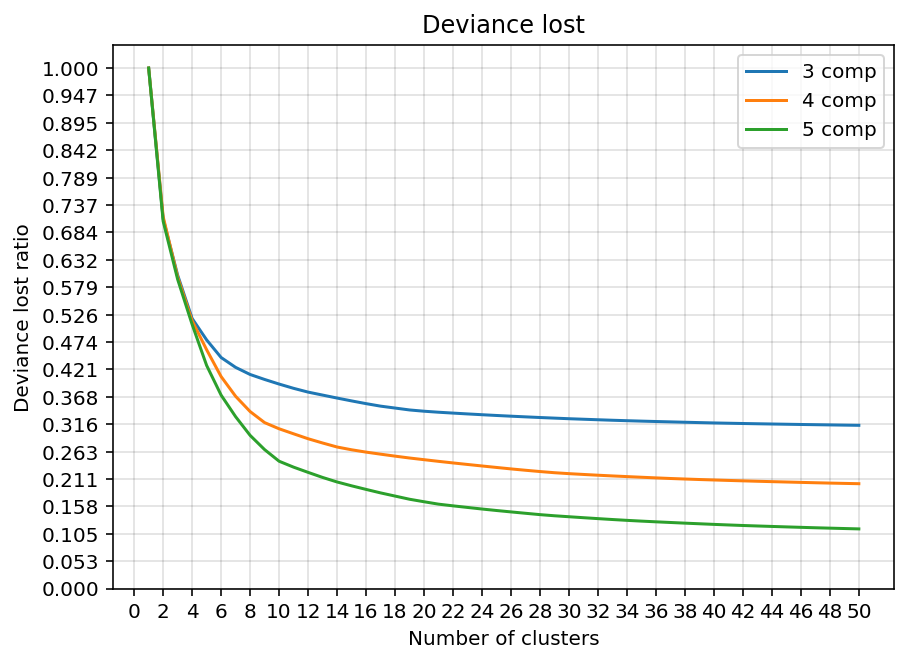

In [31]:
x = np.arange(1,nmax_cluster+1)

plt.figure(figsize=(7,5))

for i in range(nmin_comp,nmax_comp+1):
    y_dev_lost = array_dev_lost[:,i-n_comp]
    plt.plot(x, y_dev_lost)
    
c = [str(s) for s in range(nmin_comp,nmax_comp+1)]
c = [s + ' comp' for s in c]
    
plt.title('Deviance lost')
plt.ylabel('Deviance lost ratio')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(0,nmax_cluster+1,2))
plt.yticks(np.linspace(0,y_dev_lost.max(),20))
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(c)

plt.savefig("./images/Esercizio3_WC_HL_Tradeoff.svg", format = "svg")
plt.show()

In [32]:
# 4 - 8
# 4 - 10
# 3 - 8 -> bella

In [33]:
n_comp = 5
df_high_to_cluster = df_high_pca.iloc[:,0:n_comp]
df_high_to_cluster.head()

,comp 0,comp 1,comp 2,comp 3,comp 4
0,2.779448,18.814387,5.952517,12.082975,-1.048802
1,3.023143,18.827577,6.024479,12.054973,-1.035627
2,5.233477,18.380816,5.442741,12.269865,-1.157360
3,5.294401,18.384113,5.460732,12.262865,-1.154066
4,-0.096282,8.478738,-2.192427,-0.399054,4.486821


### Perform clustering

In [34]:
n_clusters = 8

clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering = clustering.fit(df_high_to_cluster.values)

In [35]:
df_high_clustered = df_no_outlier.copy()
df_high_clustered.loc[:,'cluster'] = clustering.labels_
df_high_clustered.head()

,timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,...,allThreads,URL,Latency,IdleTime,Connect,throughputType,usersType,resourceType,requestType,cluster
0,1610622816777,98,HTTP Request - Repubblica Home,200,OK,Thread Group - Slow Low 2-1,text,True,NaN,1968024,...,4,http://192.168.56.101/RepubblicaHome.html,49,0,34,slow,low,medium,slow - low - medium,7
1,1610622816777,114,HTTP Request - Repubblica Home,200,OK,Thread Group - Slow High 1-1,text,True,NaN,1968024,...,4,http://192.168.56.101/RepubblicaHome.html,49,0,34,slow,high,medium,slow - high - medium,7
2,1610622816777,124,HTTP Request - YouTube Home,200,OK,Thread Group - Fast Low 4-1,text,True,NaN,4159636,...,4,http://192.168.56.101/YouTubeHome.html,49,0,34,fast,low,large,fast - low - large,7
3,1610622816777,128,HTTP Request - YouTube Home,200,OK,Thread Group - Fast High 3-1,text,True,NaN,4159636,...,4,http://192.168.56.101/YouTubeHome.html,49,0,34,fast,high,large,fast - high - large,7
4,1610622817197,28,HTTP Request - Wikipedia Home,200,OK,Thread Group - Fast Low 4-2,text,True,NaN,71559,...,8,http://192.168.56.101/WikipediaHome.html,25,0,3,fast,low,small,fast - low - small,5


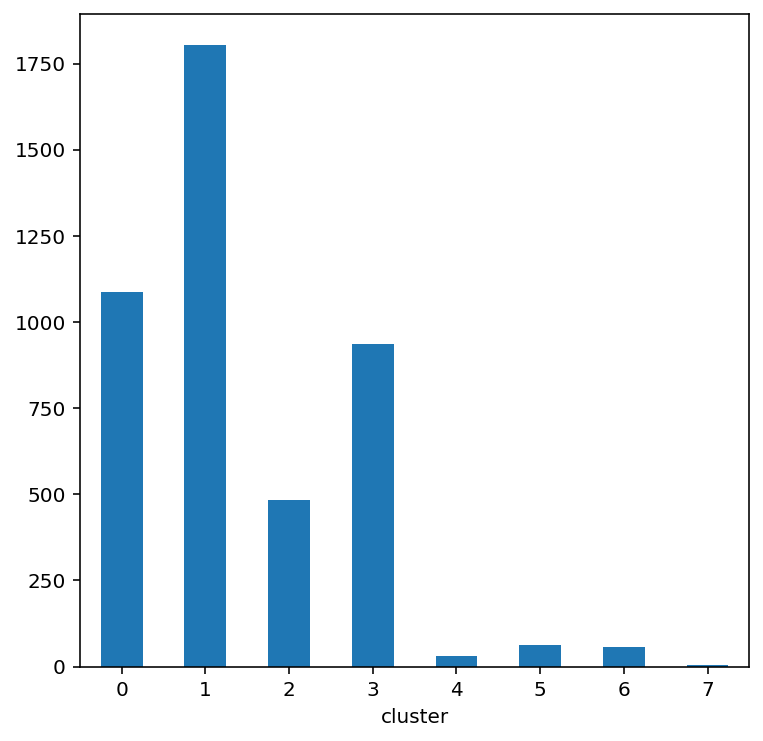

In [36]:
df_high_clustered.groupby(by='cluster').count().timeStamp.plot.bar(figsize=(6,6))
plt.xticks(rotation=0)
plt.savefig("./images/Esercizio3_WC_HL_Clu.svg", format = "svg")
plt.show()

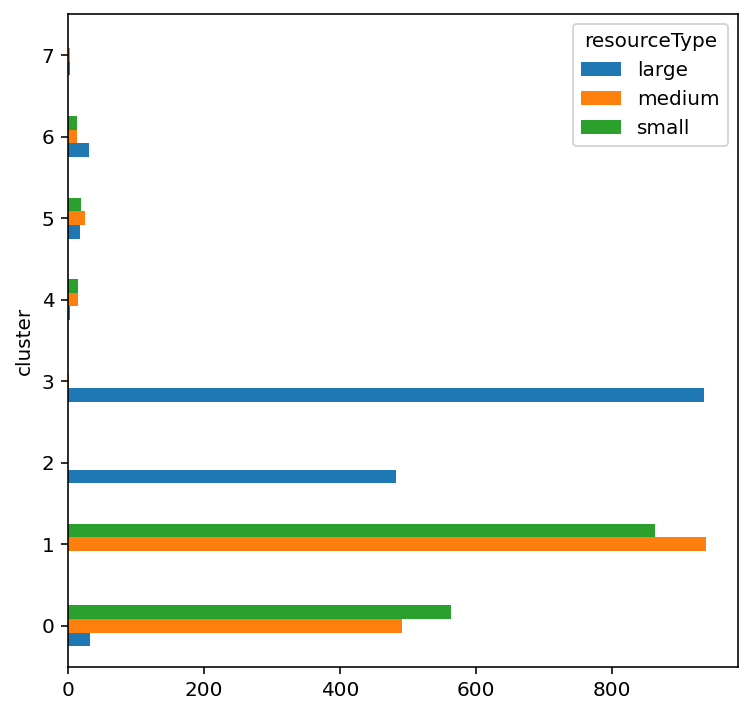

In [37]:
df_high_clustered.groupby(by=['cluster','resourceType']).count().timeStamp.unstack(1).plot.barh(figsize=(6,6))
plt.savefig("./images/Esercizio3_WC_HL_Clu_ResType.svg", format = "svg")
plt.show()

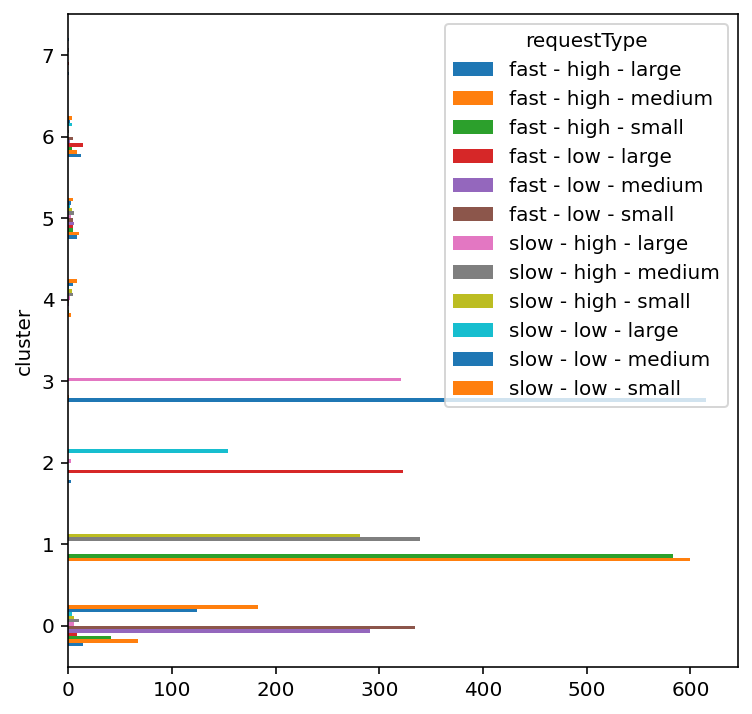

In [38]:
df_high_clustered.groupby(by=['cluster','requestType']).count().timeStamp.unstack(1).plot.barh(figsize=(6,6))
plt.savefig("./images/Esercizio3_WC_HL_Clu_ReqType.svg", format = "svg")
plt.show()

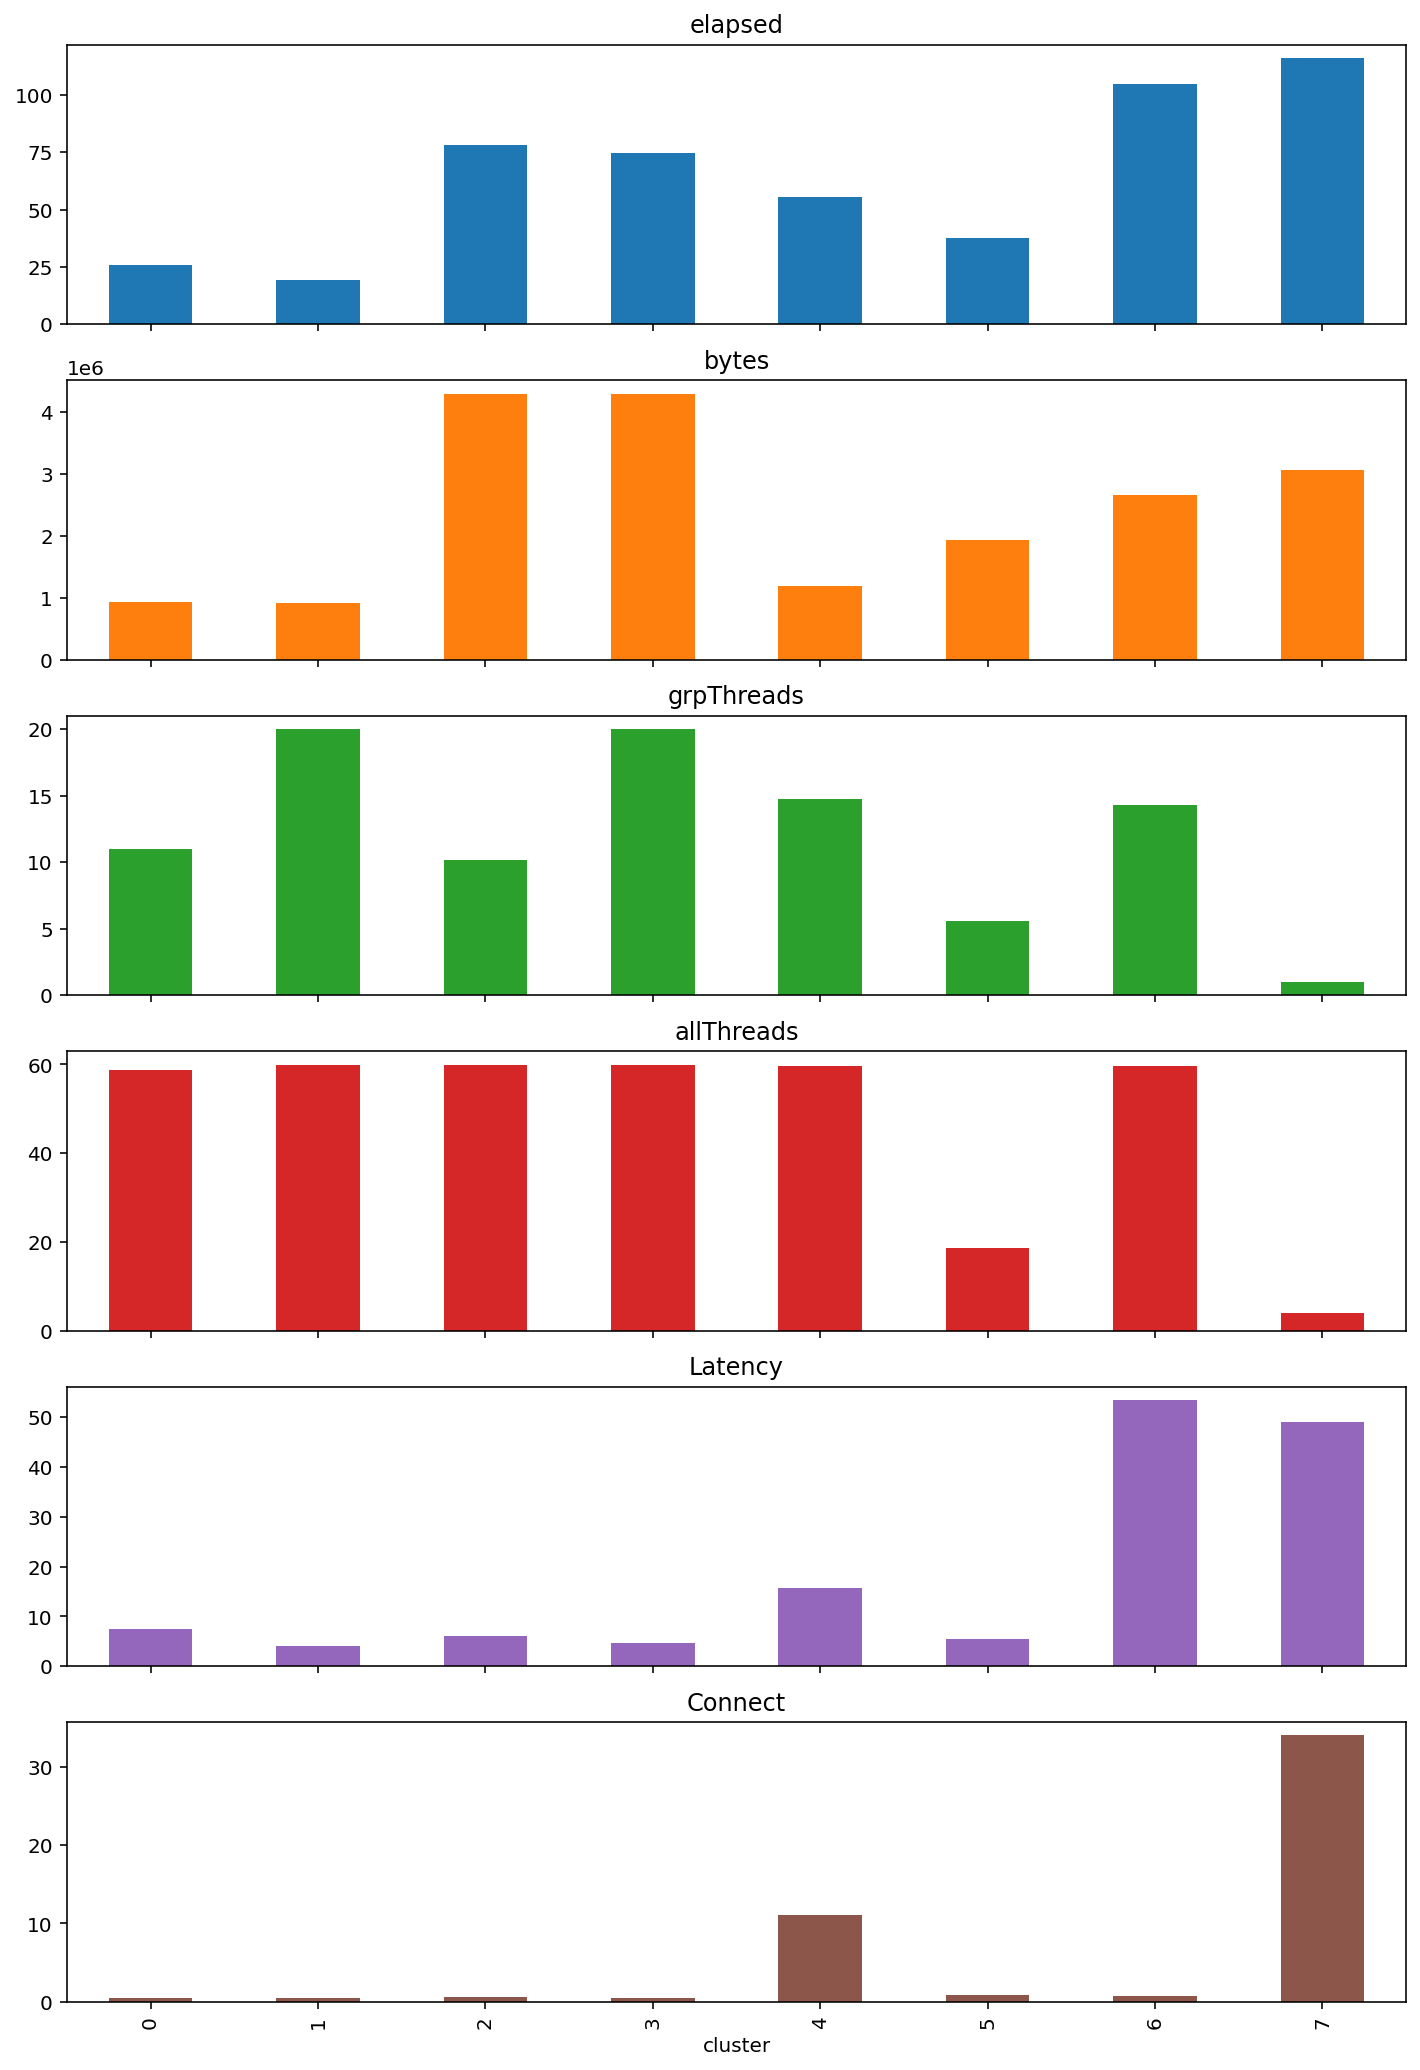

In [39]:
# codice per capire come veniva effettuato il clustering
# df_high_clustered.groupby(by=['cluster','resourceType']).describe()['Latency']
# df_high_clustered.groupby(by=['cluster','resourceType']).describe()['Connect']
df_high_clustered.drop(columns=['timeStamp','failureMessage','responseCode','sentBytes','IdleTime']).groupby(by='cluster').mean().plot(kind='bar', subplots=True, figsize=(12,18), legend=False)
plt.savefig("./images/Esercizio3_WC_HL_Clu_Group.svg", format = "svg")

plt.show()

## Synthetic workload

In [40]:
# df_high_clustered.groupby(by=['cluster','requestType']).count()

In [41]:
# df_high_clustered.groupby(by=['cluster','requestType']).count().max(level=[0,1])

In [42]:
synthetic_workload = {}

for i in range(n_clusters):
    df_cluster = df_high_clustered.groupby(by=['cluster']).get_group(i)
    requestType = df_cluster.groupby(by=['requestType']).count().timeStamp.sort_values(ascending=False).index[0]
    df_type = df_cluster.groupby(by=['requestType']).get_group(requestType)
    request = df_type.groupby(by=['label']).count().timeStamp.sort_values(ascending=False).index[0]
    synthetic_workload[i] = (requestType,request)

synthetic_workload
# Nota: il cluster 5 risulta poco denso, pertanto non viene considerato nel seguito

{0: ('fast - low - small', 'HTTP Request - Wikipedia Pag2'),
 1: ('fast - high - medium', 'HTTP Request - Repubblica Pag1'),
 2: ('fast - low - large', 'HTTP Request - YouTube Home'),
 3: ('fast - high - large', 'HTTP Request - YouTube Pag1'),
 4: ('slow - low - small', 'HTTP Request - Wikipedia Pag2'),
 5: ('fast - high - medium', 'HTTP Request - Repubblica Pag4'),
 6: ('fast - low - large', 'HTTP Request - YouTube Pag2'),
 7: ('slow - low - medium', 'HTTP Request - Repubblica Home')}

In [43]:
# df_synth = df_high_clu.groupby('cluster').apply(lambda x: x.sample())
# df_synth = df_synth.reset_index(level=0, col_level=2 , drop=True)
# df_synth

# Low level parameters

## Read data

In [44]:
df_low = pd.read_csv('WC_report_server.csv', sep='\s+', skiprows=1)
df_low.rename(columns={'r':'procs_r', 'b':'procs_b',
                       'swpd':'memory_swpd', 'free':'memory_free', 'buff':'memory_buff', 'cache':'memory_cache', 
                       'si':'swap_si', 'so':'swap_so', 
                       'bi':'io_bi', 'bo':'io_bo',
                       'in':'system_in', 'cs':'system_cs',
                       'us':'cpu_us', 'sy':'cpu_sy', 'id':'cpu_id', 'wa':'cpu_wa', 'st':'cpu_st'
                      }, inplace=True)
df_low.head()

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st
0,5,0,7488,166988,31416,1178968,3,17,2321,1730,1080,1966,20,10,54,16,0
1,0,0,7488,166988,31416,1178972,0,0,0,0,78,317,1,1,98,0,0
2,0,0,7488,166988,31416,1178972,0,0,0,0,48,102,0,0,100,0,0
3,1,0,7488,166988,31416,1178972,0,0,0,12,29,68,0,0,100,0,0
4,1,0,7488,166988,31416,1178972,0,0,0,0,62,138,2,1,97,0,0


In [45]:
print('The dataset contains', df_low.shape[1], 'columns and', df_low.shape[0], 'rows')

The dataset contains 17 columns and 310 rows


## Data analysis

In [46]:
df_low.describe()

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st
count,310.000000,310.000000,310.0,310.000000,310.000000,3.100000e+02,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.0
mean,0.187097,0.006452,7488.0,162728.941935,31969.329032,1.179490e+06,0.009677,0.054839,10.300000,15.580645,2465.022581,367.180645,0.951613,16.138710,82.432258,0.435484,0.0
std,0.531068,0.113592,0.0,3406.173355,422.918005,3.741895e+02,0.170389,0.965535,136.515787,109.150967,758.996776,147.864364,1.434970,4.889403,5.559935,1.848825,0.0
min,0.000000,0.000000,7488.0,146320.000000,31416.000000,1.178968e+06,0.000000,0.000000,0.000000,0.000000,26.000000,46.000000,0.000000,0.000000,54.000000,0.000000,0.0
25%,0.000000,0.000000,7488.0,161464.000000,31530.000000,1.179116e+06,0.000000,0.000000,0.000000,0.000000,2005.750000,311.000000,0.000000,13.250000,79.000000,0.000000,0.0
50%,0.000000,0.000000,7488.0,162120.000000,32232.000000,1.179656e+06,0.000000,0.000000,0.000000,0.000000,2511.500000,354.000000,1.000000,16.500000,82.000000,0.000000,0.0
75%,0.000000,0.000000,7488.0,164964.000000,32368.000000,1.179851e+06,0.000000,0.000000,0.000000,11.000000,3013.750000,395.000000,1.000000,19.000000,85.000000,0.000000,0.0
max,5.000000,2.000000,7488.0,166988.000000,32496.000000,1.180012e+06,3.000000,17.000000,2321.000000,1730.000000,4117.000000,1966.000000,20.000000,27.000000,100.000000,23.000000,0.0


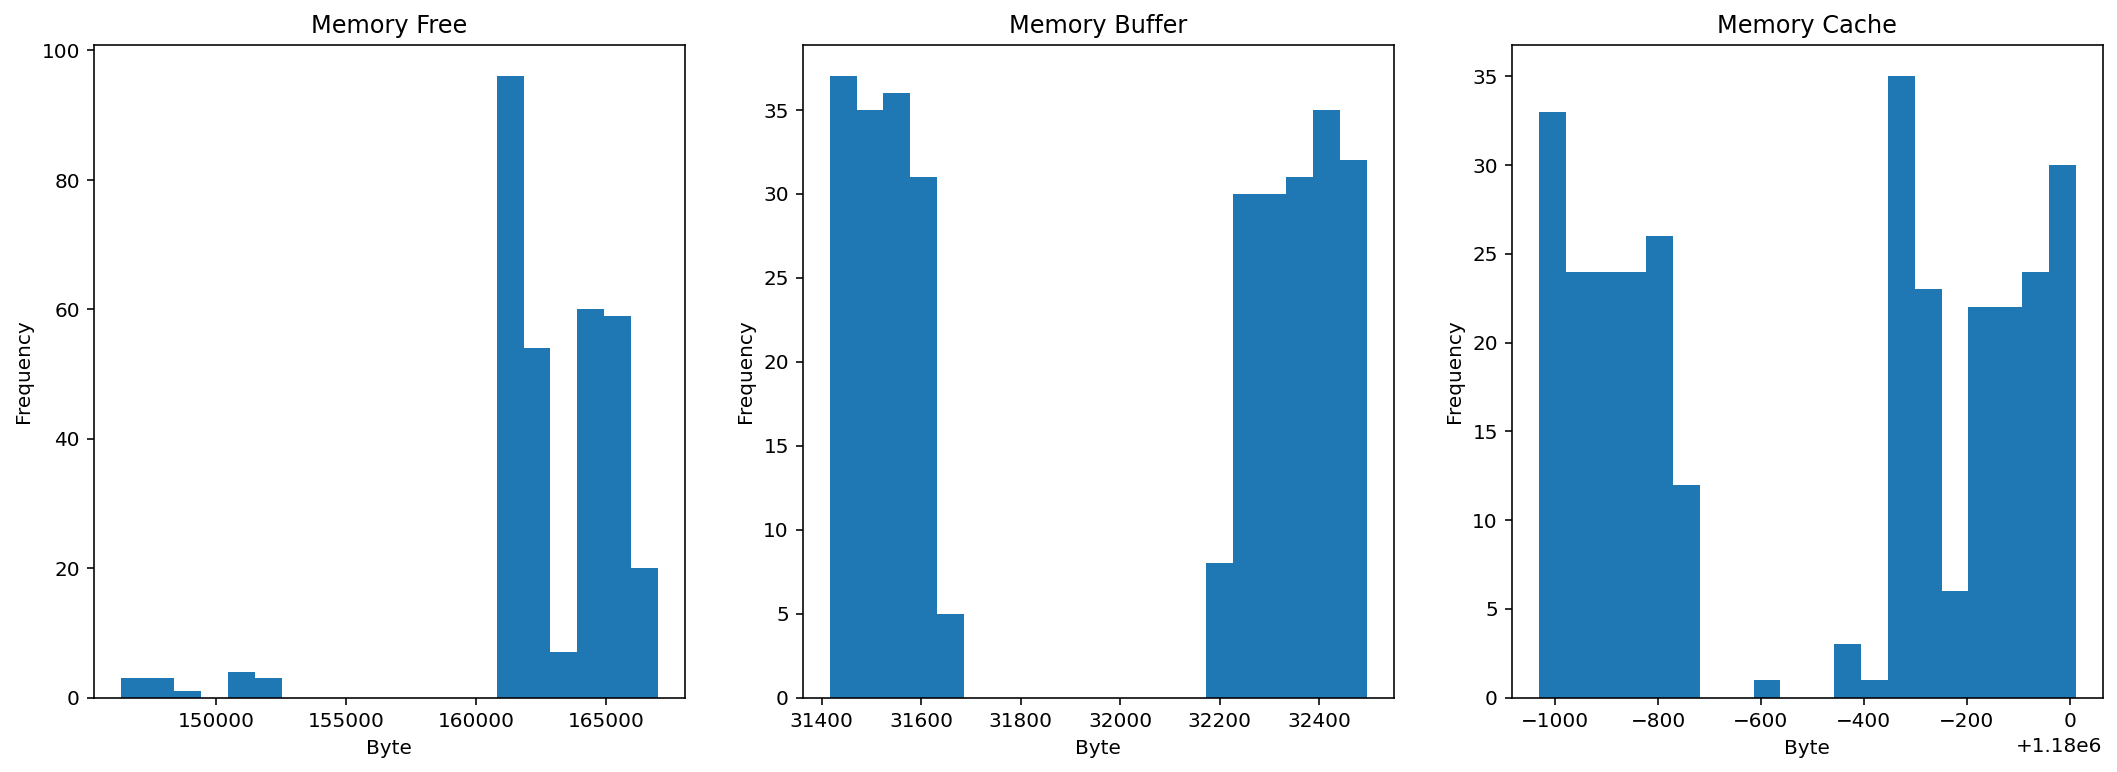

In [47]:
fig = plt.figure(figsize=(18,6))

ax0 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)

df_low.memory_free.plot.hist(bins=20, ax=ax0)
df_low.memory_buff.plot.hist(bins=20, ax=ax1)
df_low.memory_cache.plot.hist(bins=20, ax=ax2)

ax0.set_title('Memory Free')
ax0.set_xlabel('Byte')
# ax0.set_xticks(np.arange(0, max(df_high.elapsed), 5))

ax1.set_title('Memory Buffer')
ax1.set_xlabel('Byte')
# ax1.set_xticks(np.arange(0, max(df_high.Latency), 5))

ax2.set_title('Memory Cache')
ax2.set_xlabel('Byte')

plt.savefig("./images/Esercizio3_WC_LL_Mem.svg", format = "svg")

plt.show()

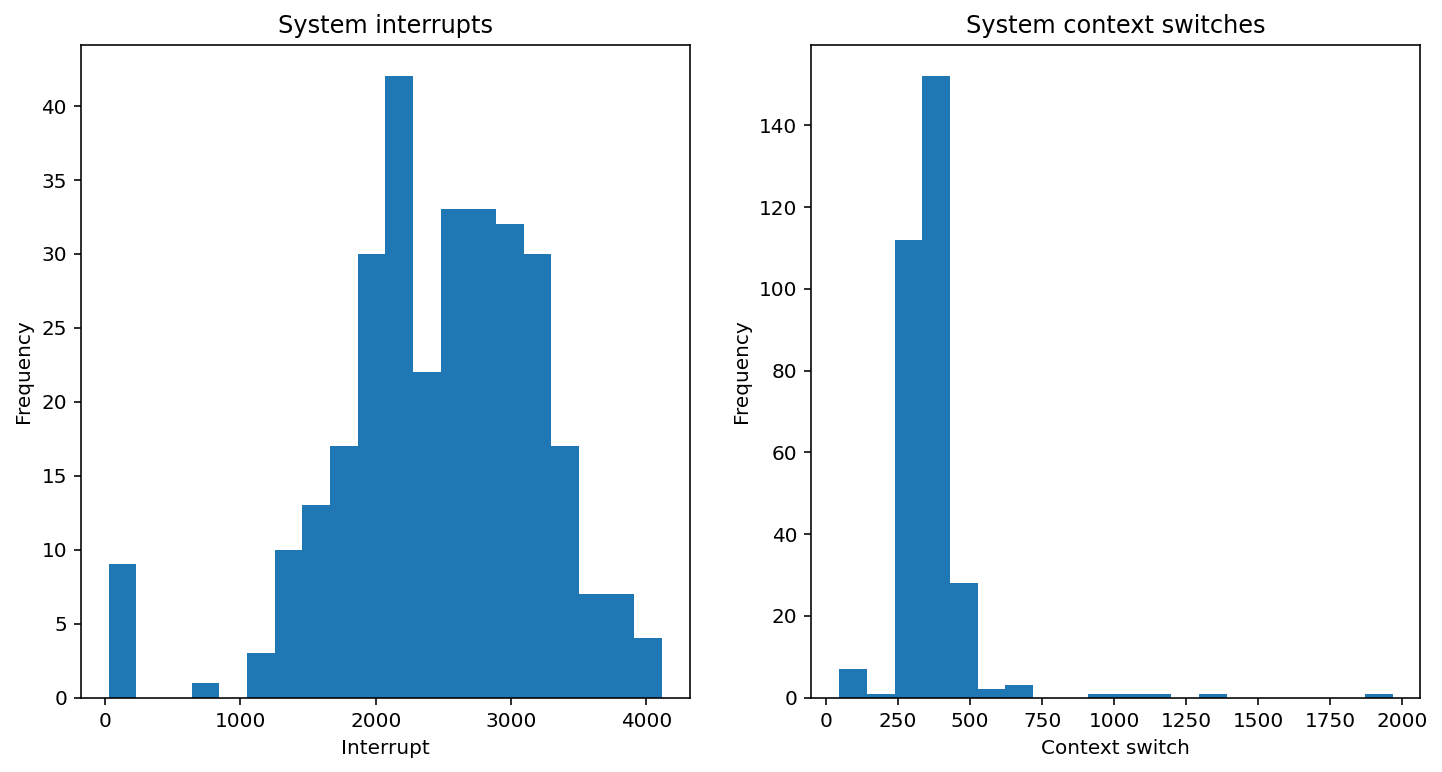

In [48]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_low.system_in.plot.hist(bins=20, ax=ax0)
df_low.system_cs.plot.hist(bins=20, ax=ax1)

ax0.set_title('System interrupts')
ax0.set_xlabel('Interrupt')

ax1.set_title('System context switches')
ax1.set_xlabel('Context switch')

plt.savefig("./images/Esercizio3_WC_LL_Int.svg", format = "svg")

plt.show()

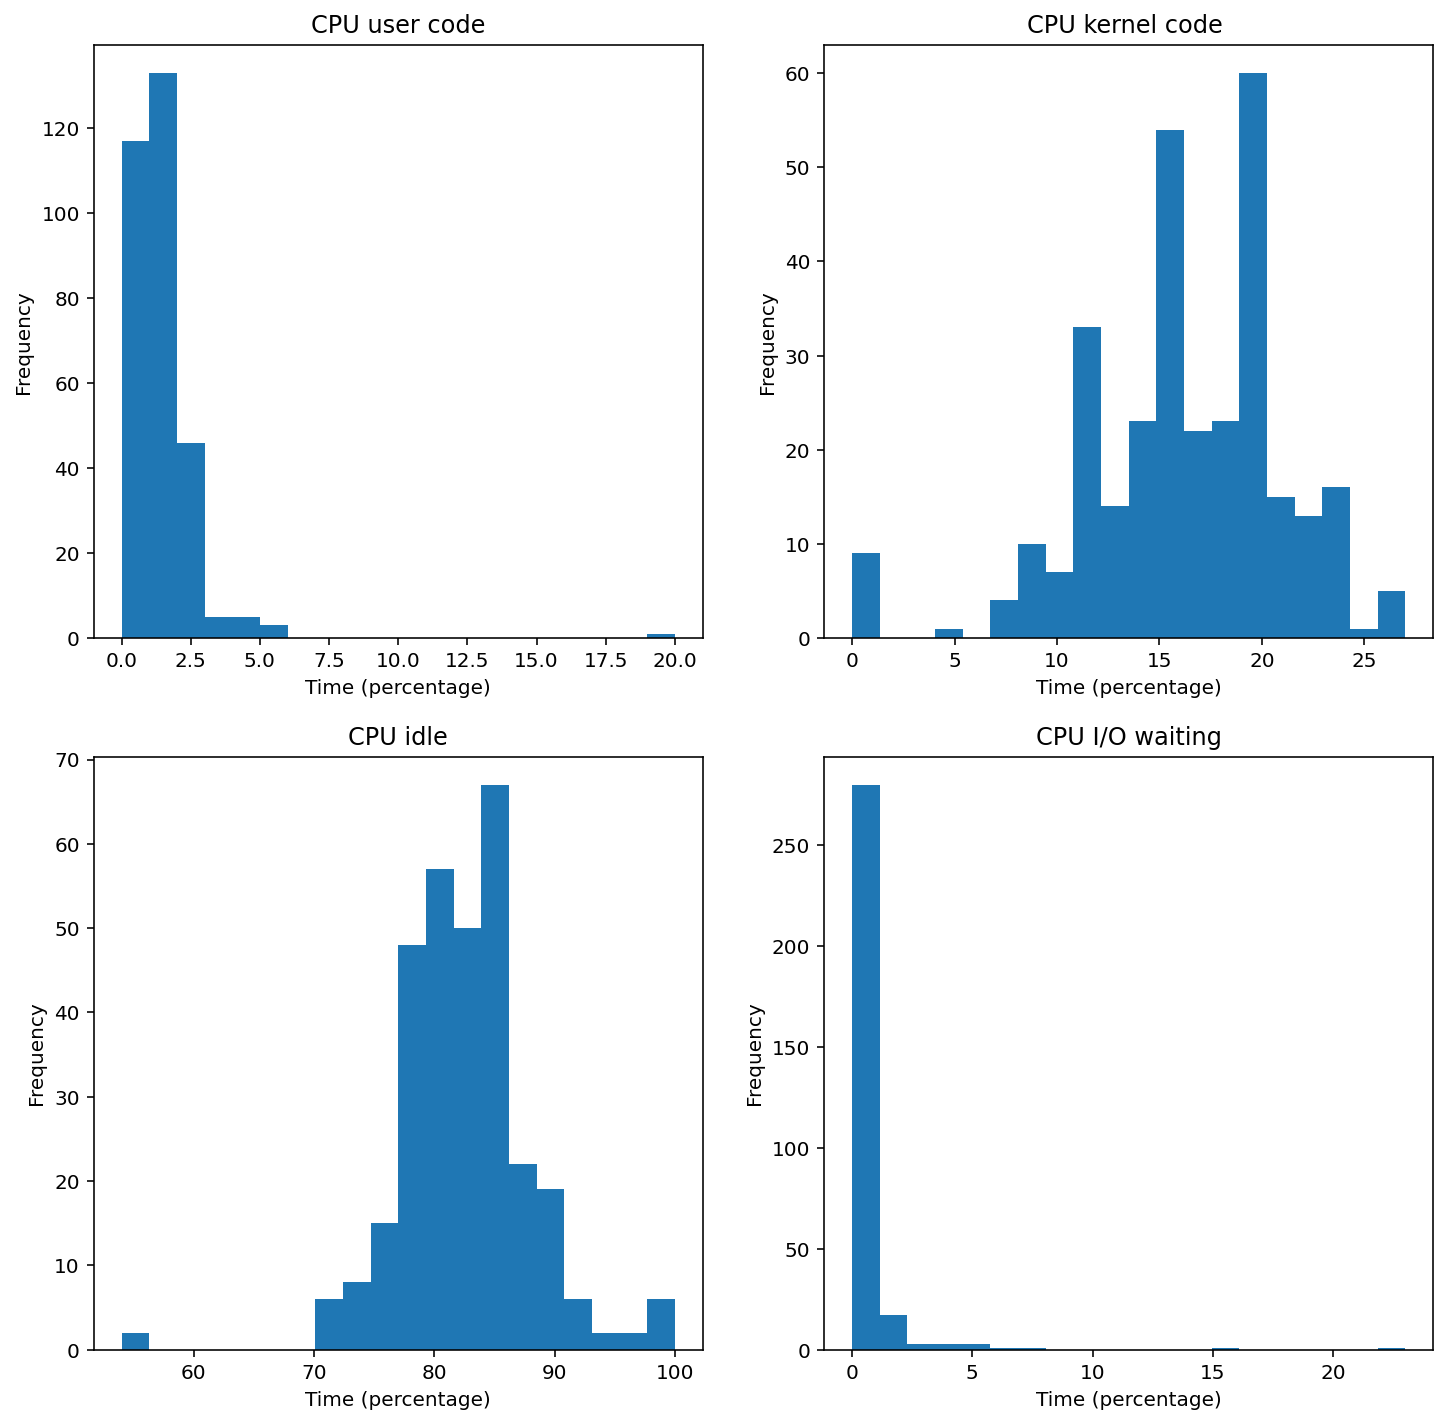

In [49]:
fig = plt.figure(figsize=(12,12))

ax0 = fig.add_subplot(2,2,1)
ax1 = fig.add_subplot(2,2,2)
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)

df_low.cpu_us.plot.hist(bins=20, ax=ax0)
df_low.cpu_sy.plot.hist(bins=20, ax=ax1)
df_low.cpu_id.plot.hist(bins=20, ax=ax2)
df_low.cpu_wa.plot.hist(bins=20, ax=ax3)

ax0.set_title('CPU user code')
ax0.set_xlabel('Time (percentage)')

ax1.set_title('CPU kernel code ')
ax1.set_xlabel('Time (percentage)')

ax2.set_title('CPU idle')
ax2.set_xlabel('Time (percentage)')

ax3.set_title('CPU I/O waiting')
ax3.set_xlabel('Time (percentage)')

plt.savefig("./images/Esercizio3_WC_LL_CPU.svg", format = "svg")
plt.show()

## PCA

### Preprocessing

#### Remove constant components

In [50]:
df_const = df_low.loc[:,df_low.columns[df_low.nunique() == 1]]
df_const.head()

,memory_swpd,cpu_st
0,7488,0
1,7488,0
2,7488,0
3,7488,0
4,7488,0


In [51]:
df_low_pre = df_low.loc[:,df_low.columns[df_low.nunique() != 1]]
df_low_pre.head()

,procs_r,procs_b,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa
0,5,0,166988,31416,1178968,3,17,2321,1730,1080,1966,20,10,54,16
1,0,0,166988,31416,1178972,0,0,0,0,78,317,1,1,98,0
2,0,0,166988,31416,1178972,0,0,0,0,48,102,0,0,100,0
3,1,0,166988,31416,1178972,0,0,0,12,29,68,0,0,100,0
4,1,0,166988,31416,1178972,0,0,0,0,62,138,2,1,97,0


#### Remove perfectly correlated components

In [52]:
df_corr = df_low_pre.corr()
df_corr

,procs_r,procs_b,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa
procs_r,1.000000,0.087219,-0.092077,-0.201627,-0.208579,0.516391,0.516391,0.526358,0.457931,-0.130422,0.322014,0.377131,-0.067358,-0.130505,0.282611
procs_b,0.087219,1.000000,-0.230734,-0.042754,-0.009514,-0.003236,-0.003236,0.069161,0.021100,-0.060285,0.065826,0.160754,-0.024924,-0.035175,0.048218
memory_free,-0.092077,-0.230734,1.000000,-0.584028,-0.556084,0.071247,0.071247,-0.017686,0.016836,-0.075324,-0.172195,-0.062764,-0.101846,0.164482,-0.163796
memory_buff,-0.201627,-0.042754,-0.584028,1.000000,0.992527,-0.074550,-0.074550,-0.065133,-0.041638,0.068309,-0.057366,-0.043664,0.032689,-0.022062,0.004522
memory_cache,-0.208579,-0.009514,-0.556084,0.992527,1.000000,-0.079561,-0.079561,-0.073478,-0.050341,0.069190,-0.070846,-0.047173,0.033286,-0.015966,-0.011463
swap_si,0.516391,-0.003236,0.071247,-0.074550,-0.079561,1.000000,1.000000,0.964457,0.894977,-0.103977,0.616110,0.756376,-0.071539,-0.291383,0.479692
swap_so,0.516391,-0.003236,0.071247,-0.074550,-0.079561,1.000000,1.000000,0.964457,0.894977,-0.103977,0.616110,0.756376,-0.071539,-0.291383,0.479692
io_bi,0.526358,0.069161,-0.017686,-0.065133,-0.073478,0.964457,0.964457,1.000000,0.864506,-0.103016,0.683204,0.756320,-0.063422,-0.355732,0.644412
io_bo,0.457931,0.021100,0.016836,-0.041638,-0.050341,0.894977,0.894977,0.864506,1.000000,-0.104828,0.562340,0.682251,-0.075205,-0.258036,0.445833
system_in,-0.130422,-0.060285,-0.075324,0.068309,0.069190,-0.103977,-0.103977,-0.103016,-0.104828,1.000000,0.316316,0.011387,0.933409,-0.794622,-0.095532


In [53]:
# mask = np.ones(df_corr.shape, dtype='bool')
# mask[np.triu_indices(len(df_corr))] = False

# corr_comp = (df_corr == 1 & mask).values.nonzero()
# corr_comp = [val[0] for val in corr_comp]

# df_low_pre.columns[corr_comp]

In [54]:
# df_low_pre = df_low_pre.drop(df_low_pre.columns[corr_comp[0]], axis=1)
# df_low_pre.head()

#### Normalize the components

In [55]:
x = df_low_pre.values

x_scaled = StandardScaler().fit_transform(x)

df_low_pre = pd.DataFrame(data=x_scaled, columns=df_low_pre.columns )
df_low_pre.head()

,procs_r,procs_b,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa
0,9.077334,-0.056888,1.252415,-1.310475,-1.398549,17.578396,17.578396,16.953614,15.732259,-1.827757,10.830225,13.295874,-1.257543,-5.122044,8.432210
1,-0.352872,-0.056888,1.252415,-1.310475,-1.387842,-0.056888,-0.056888,-0.075571,-0.142975,-3.150055,-0.339918,0.033774,-3.101235,2.804514,-0.235927
2,-0.352872,-0.056888,1.252415,-1.310475,-1.387842,-0.056888,-0.056888,-0.075571,-0.142975,-3.189645,-1.796304,-0.664231,-3.306089,3.164812,-0.235927
3,1.533169,-0.056888,1.252415,-1.310475,-1.387842,-0.056888,-0.056888,-0.075571,-0.032858,-3.214719,-2.026617,-0.664231,-3.306089,3.164812,-0.235927
4,1.533169,-0.056888,1.252415,-1.310475,-1.387842,-0.056888,-0.056888,-0.075571,-0.142975,-3.171170,-1.552444,0.731780,-3.101235,2.624365,-0.235927


### Perform PCA

In [57]:
pca = PCA()

princ_comp = pca.fit(df_low_pre.values)

In [58]:
d = pca.transform(df_low_pre.values)

c = [str(s) for s in range(princ_comp.n_components_)]
c = ['comp ' + s for s in c]

df_low_pca = pd.DataFrame(data=d, columns=c)
df_low_pca.head()

,comp 0,comp 1,comp 2,comp 3,comp 4,comp 5,comp 6,comp 7,comp 8,comp 9,comp 10,comp 11,comp 12,comp 13,comp 14
0,39.815158,5.615847,1.842362,-3.060508,-2.308821,0.170817,-0.919199,0.665205,-0.023286,-0.838671,-0.025927,-0.091148,0.002830,0.000086,-7.307320e-15
1,-1.045004,5.420893,-0.017984,0.157811,0.203508,-0.902572,1.088906,-0.164589,0.612326,0.003436,-0.007195,0.013113,0.055786,-0.005353,-4.194870e-16
2,-1.851808,6.013909,0.178401,0.003865,0.209927,-0.618110,0.138193,0.298598,-0.074933,-0.194513,0.026617,0.081140,0.052416,0.004866,-2.875464e-16
3,-1.442549,6.315568,0.164270,0.399195,0.366962,0.985871,-0.269922,-0.302430,-0.131062,0.086155,0.052771,0.089474,0.061293,0.007236,-3.210542e-16
4,-0.721284,5.826566,0.015911,0.548496,0.105999,0.703272,0.589591,-1.055640,-0.575418,0.234803,-0.157968,0.089012,0.061740,-0.002631,-5.774271e-16


#### Explained variance

In [59]:
d = {'explained variance': princ_comp.explained_variance_, 'explained variance ratio': princ_comp.explained_variance_ratio_}

df_variance_PCA = pd.DataFrame(data=d)

df_variance_PCA['cumulative explained variance ratio'] = df_variance_PCA.cumsum()['explained variance ratio']
df_variance_PCA

,explained variance,explained variance ratio,cumulative explained variance ratio
0,5.822452e+00,3.869114e-01,0.386911
1,3.001929e+00,1.994830e-01,0.586394
2,2.366713e+00,1.572719e-01,0.743666
3,1.165714e+00,7.746358e-02,0.821130
4,7.905894e-01,5.253594e-02,0.873666
5,7.340677e-01,4.877998e-02,0.922446
6,4.470383e-01,2.970641e-02,0.952152
7,2.977283e-01,1.978452e-02,0.971937
8,1.866489e-01,1.240312e-02,0.984340
9,1.406448e-01,9.346076e-03,0.993686


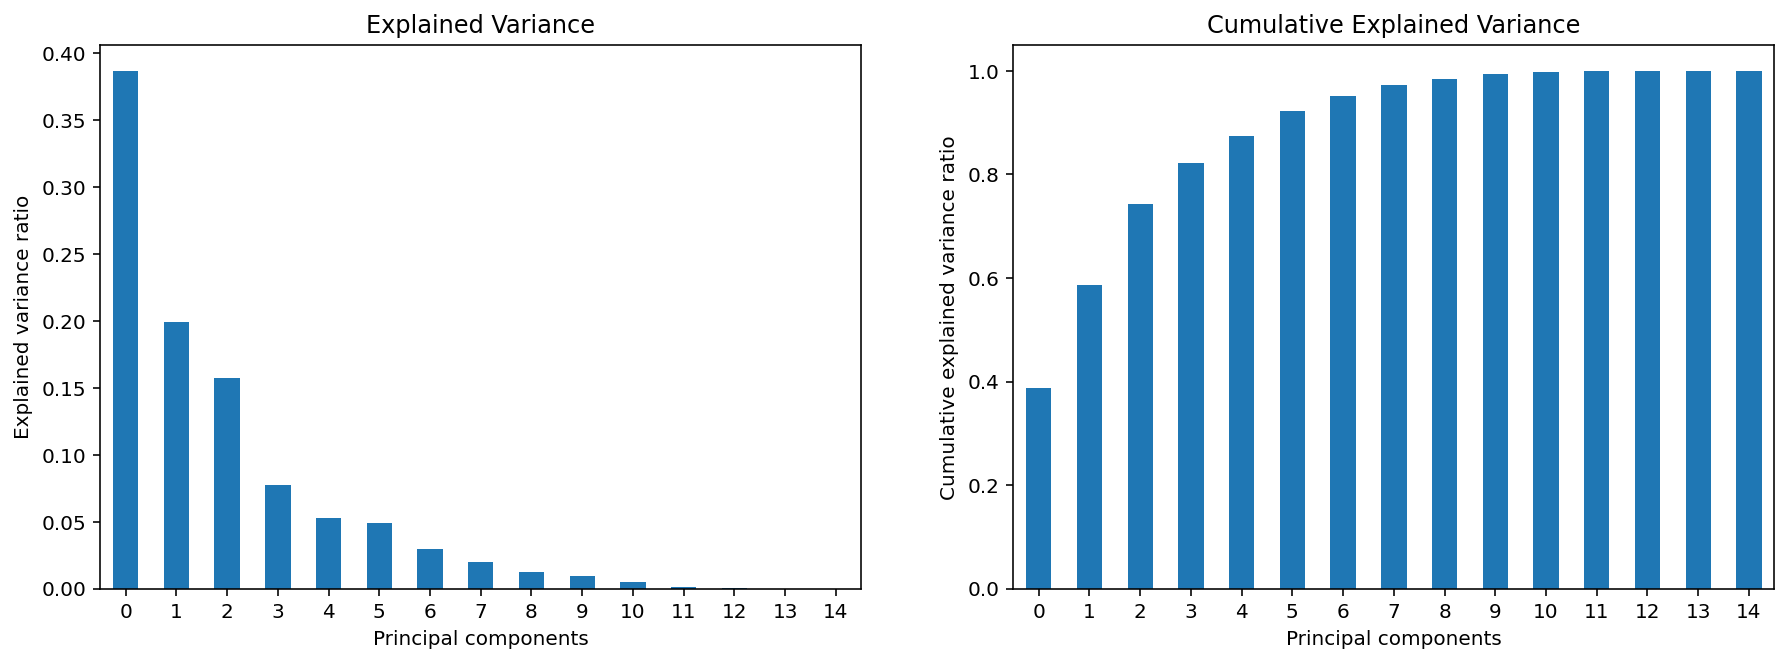

In [60]:
fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

df_variance_PCA.plot.bar(y=['explained variance ratio'], ax=ax0, legend=False)
df_variance_PCA.plot.bar(y=['cumulative explained variance ratio'], ax=ax1, legend=False)

ax0.tick_params(labelrotation=0)
ax0.set_title('Explained Variance')
ax0.set_xlabel('Principal components')
ax0.set_ylabel('Explained variance ratio')

ax1.tick_params(labelrotation=0)
ax1.set_title('Cumulative Explained Variance')
ax1.set_xlabel('Principal components')
ax1.set_ylabel('Cumulative explained variance ratio')

fig.savefig("./images/Esercizio3_WC_LL_PCA.svg", format = "svg")
plt.show()

## Clustering

### Select principal components

In [108]:
dev_tot = df_low_pre.sub(df_low_pre.mean()).pow(2).sum().sum()

nmin_comp = 4
nmax_comp = 8
n_comp = nmax_comp-nmin_comp+1

nmax_cluster = 50

array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
filepath = './array_dev_lost_low.txt'
if(not os.path.isfile(filepath)):
    print('Creating file', filepath, 'this may take a while...\n')
    
    array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
    
    for i in tqdmn(range(nmin_comp, nmax_comp+1), desc='outer loop'):

        for j in tqdmn(range(1, nmax_cluster+1), desc='inner loop'):
            df_clustering = df_low_pca.iloc[:,0:i]

            # clustering
            clustering = AgglomerativeClustering(n_clusters=j)
            clustering = clustering.fit(df_clustering.values)

            df_clustering.insert(len(df_clustering.columns), 'cluster', clustering.labels_)

            # deviance PCA
            df_pca = df_low_pca.iloc[:,0:i]
            dev_pca = df_pca.sub(df_pca.mean()).pow(2).sum().sum()

            # deviance clustering 
            n_elem = df_clustering.groupby('cluster').count().values[:,0]
            centroids = df_clustering.groupby('cluster').mean()

            # intra-cluster deviance
            arr = np.zeros(shape=(j,1))
            for k in range(j):
                elem_k = df_clustering.loc[df_clustering['cluster'] == k].drop(columns='cluster')
                arr[k] = elem_k.sub(centroids.loc[k,:]).pow(2).sum().sum()
            dev_intra = arr.sum()

            # inter-cluster deviance
            dev_inter = centroids.sub(df_clustering.mean()).pow(2).mul(n_elem, axis=0).sum().sum()
            dev_inter

            # deviance lost
            dev_pca_ratio = dev_pca/dev_tot
            dev_inter_ratio = dev_inter/dev_pca
            dev_lost = 1 - dev_inter_ratio * dev_pca_ratio

            array_dev_lost[j-1][i-n_comp+1] = dev_lost

#             print(array_dev_lost)
    with open (filepath, 'wb') as fp:
        pickle.dump(array_dev_lost, fp)

else:
    print('File already exists!\n')
    with open (filepath, 'rb') as fp:
        array_dev_lost = pickle.load(fp)
        
        
# array_dev_lost

File already exists!



In [109]:
array_dev_lost

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.64842599, 0.6472759 , 0.64726961, 0.64708731, 0.64699184],
       [0.49580665, 0.50915785, 0.50913485, 0.5134374 , 0.5104592 ],
       [0.42472548, 0.41934345, 0.42374004, 0.43822949, 0.42735319],
       [0.36078836, 0.35005079, 0.35162562, 0.36492375, 0.35429765],
       [0.31895764, 0.30333459, 0.30301946, 0.3155019 , 0.30575715],
       [0.28922132, 0.25889964, 0.25668301, 0.27335322, 0.25996485],
       [0.26745712, 0.23098486, 0.2292956 , 0.24340628, 0.22761547],
       [0.24839482, 0.21874855, 0.20970224, 0.21968761, 0.19965761],
       [0.24084499, 0.20855911, 0.19122733, 0.19735384, 0.17431607],
       [0.23335106, 0.20054806, 0.18180578, 0.179999  , 0.16382129],
       [0.22719152, 0.19348139, 0.17329823, 0.1643783 , 0.1540748 ],
       [0.22183276, 0.1865343 , 0.16522268, 0.15552614, 0.14500413],
       [0.21790179, 0.18102125, 0.15794589, 0.14742064, 0.13673245],
       [0.21509516, 0.17614102, 0.

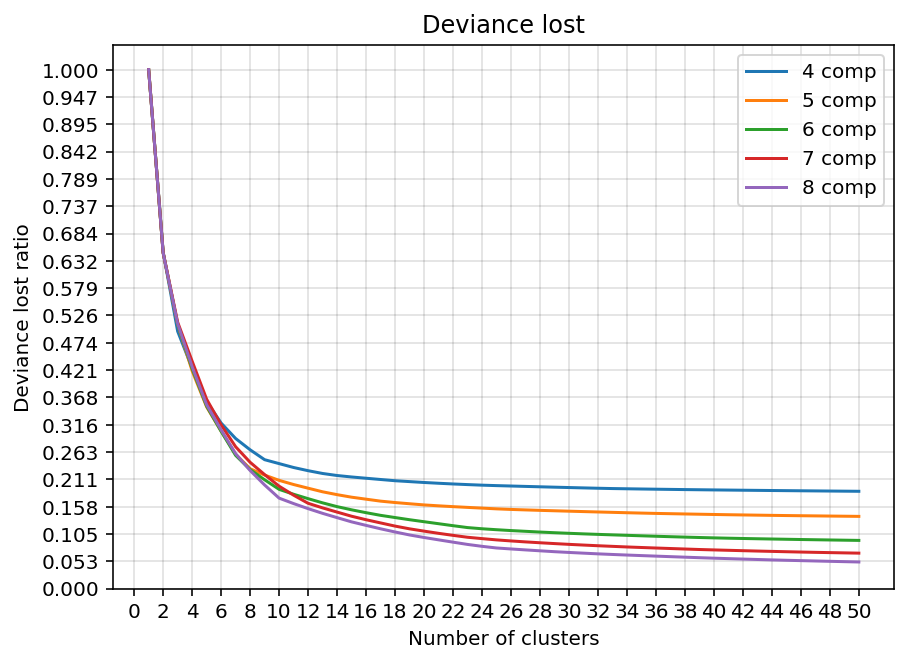

In [110]:
x = np.arange(1,nmax_cluster+1)

plt.figure(figsize=(7,5))

for i in range(nmin_comp,nmax_comp+1):
    y_dev_lost = array_dev_lost[:,i-n_comp+1]
    plt.plot(x, y_dev_lost)
    
c = [str(s) for s in range(nmin_comp,nmax_comp+1)]
c = [s + ' comp' for s in c]
    
plt.title('Deviance lost')
plt.ylabel('Deviance lost ratio')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(0,nmax_cluster+1,2))
plt.yticks(np.linspace(0,y_dev_lost.max(),20))
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(c)

plt.savefig("./images/Esercizio3_WC_LL_Tradeoff.svg", format = "svg")
plt.show()

In [65]:
n_comp = 8
df_low_cl = df_low_pca.iloc[:,0:n_comp]
df_low_cl.head()

,comp 0,comp 1,comp 2,comp 3,comp 4,comp 5,comp 6,comp 7
0,39.815158,5.615847,1.842362,-3.060508,-2.308821,0.170817,-0.919199,0.665205
1,-1.045004,5.420893,-0.017984,0.157811,0.203508,-0.902572,1.088906,-0.164589
2,-1.851808,6.013909,0.178401,0.003865,0.209927,-0.618110,0.138193,0.298598
3,-1.442549,6.315568,0.164270,0.399195,0.366962,0.985871,-0.269922,-0.302430
4,-0.721284,5.826566,0.015911,0.548496,0.105999,0.703272,0.589591,-1.055640


### Perform clustering

In [66]:
n_clusters = 20

clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering = clustering.fit(df_low_cl.values)

In [67]:
df_low_clustered = df_low.copy()
df_low
df_low_clustered.loc[:,'cluster'] = clustering.labels_
df_low_clustered.head()

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st,cluster
0,5,0,7488,166988,31416,1178968,3,17,2321,1730,1080,1966,20,10,54,16,0,15
1,0,0,7488,166988,31416,1178972,0,0,0,0,78,317,1,1,98,0,0,13
2,0,0,7488,166988,31416,1178972,0,0,0,0,48,102,0,0,100,0,0,13
3,1,0,7488,166988,31416,1178972,0,0,0,12,29,68,0,0,100,0,0,13
4,1,0,7488,166988,31416,1178972,0,0,0,0,62,138,2,1,97,0,0,13


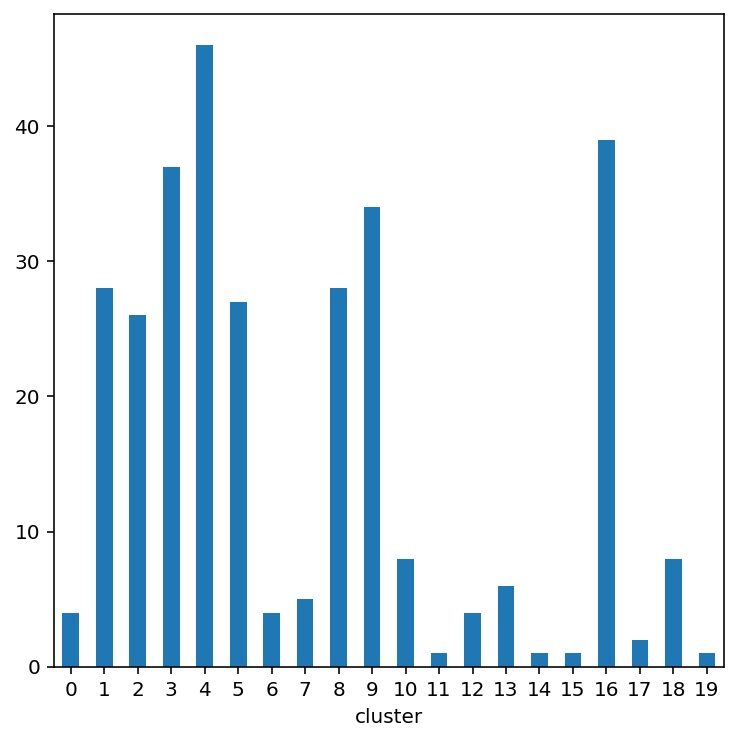

In [68]:
df_low_clustered.groupby(by='cluster').count().procs_r.plot.bar(figsize=(6,6))
plt.xticks(rotation=0)
plt.savefig("./images/Esercizio3_WC_LL_Clu.svg", format = "svg")
plt.show()

In [69]:
df_low_pca.loc[:,'cluster'] = clustering.labels_
df_low_pca

,comp 0,comp 1,comp 2,comp 3,comp 4,comp 5,comp 6,comp 7,comp 8,comp 9,comp 10,comp 11,comp 12,comp 13,comp 14,cluster
0,39.815158,5.615847,1.842362,-3.060508,-2.308821,0.170817,-0.919199,0.665205,-0.023286,-0.838671,-0.025927,-0.091148,0.002830,0.000086,-7.307320e-15,15
1,-1.045004,5.420893,-0.017984,0.157811,0.203508,-0.902572,1.088906,-0.164589,0.612326,0.003436,-0.007195,0.013113,0.055786,-0.005353,-4.194870e-16,13
2,-1.851808,6.013909,0.178401,0.003865,0.209927,-0.618110,0.138193,0.298598,-0.074933,-0.194513,0.026617,0.081140,0.052416,0.004866,-2.875464e-16,13
3,-1.442549,6.315568,0.164270,0.399195,0.366962,0.985871,-0.269922,-0.302430,-0.131062,0.086155,0.052771,0.089474,0.061293,0.007236,-3.210542e-16,13
4,-0.721284,5.826566,0.015911,0.548496,0.105999,0.703272,0.589591,-1.055640,-0.575418,0.234803,-0.157968,0.089012,0.061740,-0.002631,-5.774271e-16,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,0.042049,-2.282390,0.687303,-0.671298,-0.567031,-0.138590,-0.475119,-0.472463,0.256208,0.102522,-0.235260,0.039307,-0.080549,-0.005727,1.847677e-16,8
306,-1.724829,3.087361,3.009135,-0.605686,-0.201881,-0.288007,-0.419911,-0.247566,0.214112,-0.124734,-0.190086,0.074228,-0.092487,0.003268,-3.780414e-16,6
307,-2.201300,4.587616,3.672321,-0.592756,-0.184451,-0.328750,-0.397915,-0.229926,-0.067340,-0.155614,-0.084425,0.096483,-0.098645,0.004533,-5.903124e-16,6
308,-1.162124,3.981702,3.492569,-0.383499,-0.107533,-0.726962,0.970776,-0.770246,1.273086,0.096220,0.185130,-0.029803,-0.094223,-0.011338,-7.648552e-16,6


In [70]:
# pd.set_option('display.max_rows', 50)
# df_low_clustered.groupby(by='cluster').mean()
# sns.barplot(x='cluster', columns=df_low_clu.columns, data=df_low_clu)
# plt.show()

## Synthetic workload

In [71]:
df_synth_real = df_low_pca.groupby('cluster').apply(lambda x: x.sample())
df_synth_real = df_synth_real.reset_index(level=0, col_level=2 , drop=True)
df_synth_real

,comp 0,comp 1,comp 2,comp 3,comp 4,comp 5,comp 6,comp 7,comp 8,comp 9,comp 10,comp 11,comp 12,comp 13,comp 14,cluster
160,1.107148,-2.192715,1.098142,2.034142,1.066535,5.725370,-0.272058,0.109487,-0.317099,-0.061239,0.044187,-0.089498,0.056741,0.006580,-1.104814e-16,0
270,-0.784843,0.765890,2.068896,-0.355870,-0.285033,-0.184045,0.070500,-0.231246,-0.038310,-0.082830,-0.239619,0.043607,-0.069306,-0.003105,-2.950614e-16,1
36,-0.036976,0.914804,-1.507764,0.617205,0.401696,1.471534,-0.174301,0.159453,0.239043,-0.077582,0.205844,-0.013195,0.015592,0.002269,2.243778e-16,2
16,-0.039170,-0.109725,-2.320755,-0.036318,-0.178068,-0.334668,-0.024810,0.162593,-0.254887,-0.096915,0.116236,0.040906,0.055498,-0.004337,3.550934e-16,3
300,-0.382150,0.047734,1.964891,-0.391974,-0.536784,-0.257111,0.226761,-0.577867,-0.477089,0.081017,-0.343717,0.065372,-0.107228,-0.006781,-3.957000e-16,4
100,-0.496977,1.613938,-0.806703,0.045719,-0.041728,-0.396124,0.321544,0.135878,-0.145678,-0.108353,-0.162355,0.035370,-0.066812,-0.000775,-4.167589e-17,5
309,-1.258345,4.179523,3.770123,-0.296603,1.952463,-1.220599,-1.278364,-0.607824,-0.661752,0.267627,-0.123897,-0.353303,-0.053356,-0.008716,-6.311721e-16,6
32,0.548397,1.141721,-1.296468,0.360721,2.086668,-1.331581,-0.516760,-0.213873,-0.673457,0.321964,0.178931,-0.425691,0.070998,-0.018286,1.205789e-17,7
231,0.088373,-2.581108,0.259895,-0.447494,-0.466962,0.000831,-0.251281,-0.140779,0.074243,-0.075644,0.323237,0.007124,0.004873,-0.010249,2.214693e-16,8
96,-0.559149,0.269001,-1.488610,-0.102587,-0.036257,-0.124540,-0.373943,0.547263,-0.058508,-0.240097,0.298639,0.025321,-0.054357,0.001262,3.202884e-16,9


In [72]:
df_synth_real.to_csv('df_synth_real.csv', index=False)

# Low level parameters 2

## Read data

In [73]:
df_low = pd.read_csv('WC_report_server_synth.csv', sep='\s+', skiprows=1)
df_low.rename(columns={'r':'procs_r', 'b':'procs_b',
                       'swpd':'memory_swpd', 'free':'memory_free', 'buff':'memory_buff', 'cache':'memory_cache', 
                       'si':'swap_si', 'so':'swap_so', 
                       'bi':'io_bi', 'bo':'io_bo',
                       'in':'system_in', 'cs':'system_cs',
                       'us':'cpu_us', 'sy':'cpu_sy', 'id':'cpu_id', 'wa':'cpu_wa', 'st':'cpu_st'
                      }, inplace=True)
df_low.head()

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st
0,3,0,14168,85676,37408,1182752,0,2,239,203,205,256,3,2,94,2,0
1,0,1,14168,85668,37416,1182756,0,0,0,52,108,455,8,1,91,0,0
2,0,0,14168,85668,37416,1182756,0,0,0,0,67,191,3,0,91,6,0
3,1,0,14168,85668,37416,1182756,0,0,0,0,42,83,0,0,100,0,0
4,0,0,14168,85668,37416,1182756,0,0,0,0,37,102,1,0,99,0,0


In [74]:
print('The dataset contains', df_low.shape[1], 'columns and', df_low.shape[0], 'rows')

The dataset contains 17 columns and 310 rows


## Data analysis

In [75]:
df_low.describe()

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st
count,310.000000,310.000000,310.0,310.000000,310.000000,3.100000e+02,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.0
mean,0.490323,0.009677,14168.0,115980.400000,37695.870968,1.183336e+06,0.025806,0.006452,1.945161,16.564516,2739.277419,359.796774,1.332258,17.641935,80.780645,0.219355,0.0
std,1.235231,0.098055,0.0,5498.651762,164.735689,2.443207e+02,0.454369,0.113592,20.171118,77.405297,706.246274,96.667719,1.262834,4.638119,4.739521,0.970577,0.0
min,0.000000,0.000000,14168.0,85668.000000,37408.000000,1.182748e+06,0.000000,0.000000,0.000000,0.000000,29.000000,49.000000,0.000000,0.000000,62.000000,0.000000,0.0
25%,0.000000,0.000000,14168.0,116522.000000,37560.000000,1.183141e+06,0.000000,0.000000,0.000000,0.000000,2429.250000,315.000000,1.000000,15.000000,78.000000,0.000000,0.0
50%,0.000000,0.000000,14168.0,118366.000000,37680.000000,1.183288e+06,0.000000,0.000000,0.000000,0.000000,2808.500000,353.500000,1.000000,18.000000,80.000000,0.000000,0.0
75%,0.000000,0.000000,14168.0,118676.000000,37846.000000,1.183567e+06,0.000000,0.000000,0.000000,16.000000,3202.000000,391.000000,2.000000,21.000000,83.000000,0.000000,0.0
max,8.000000,1.000000,14168.0,118676.000000,37968.000000,1.183708e+06,8.000000,2.000000,239.000000,988.000000,4108.000000,929.000000,8.000000,26.000000,100.000000,13.000000,0.0


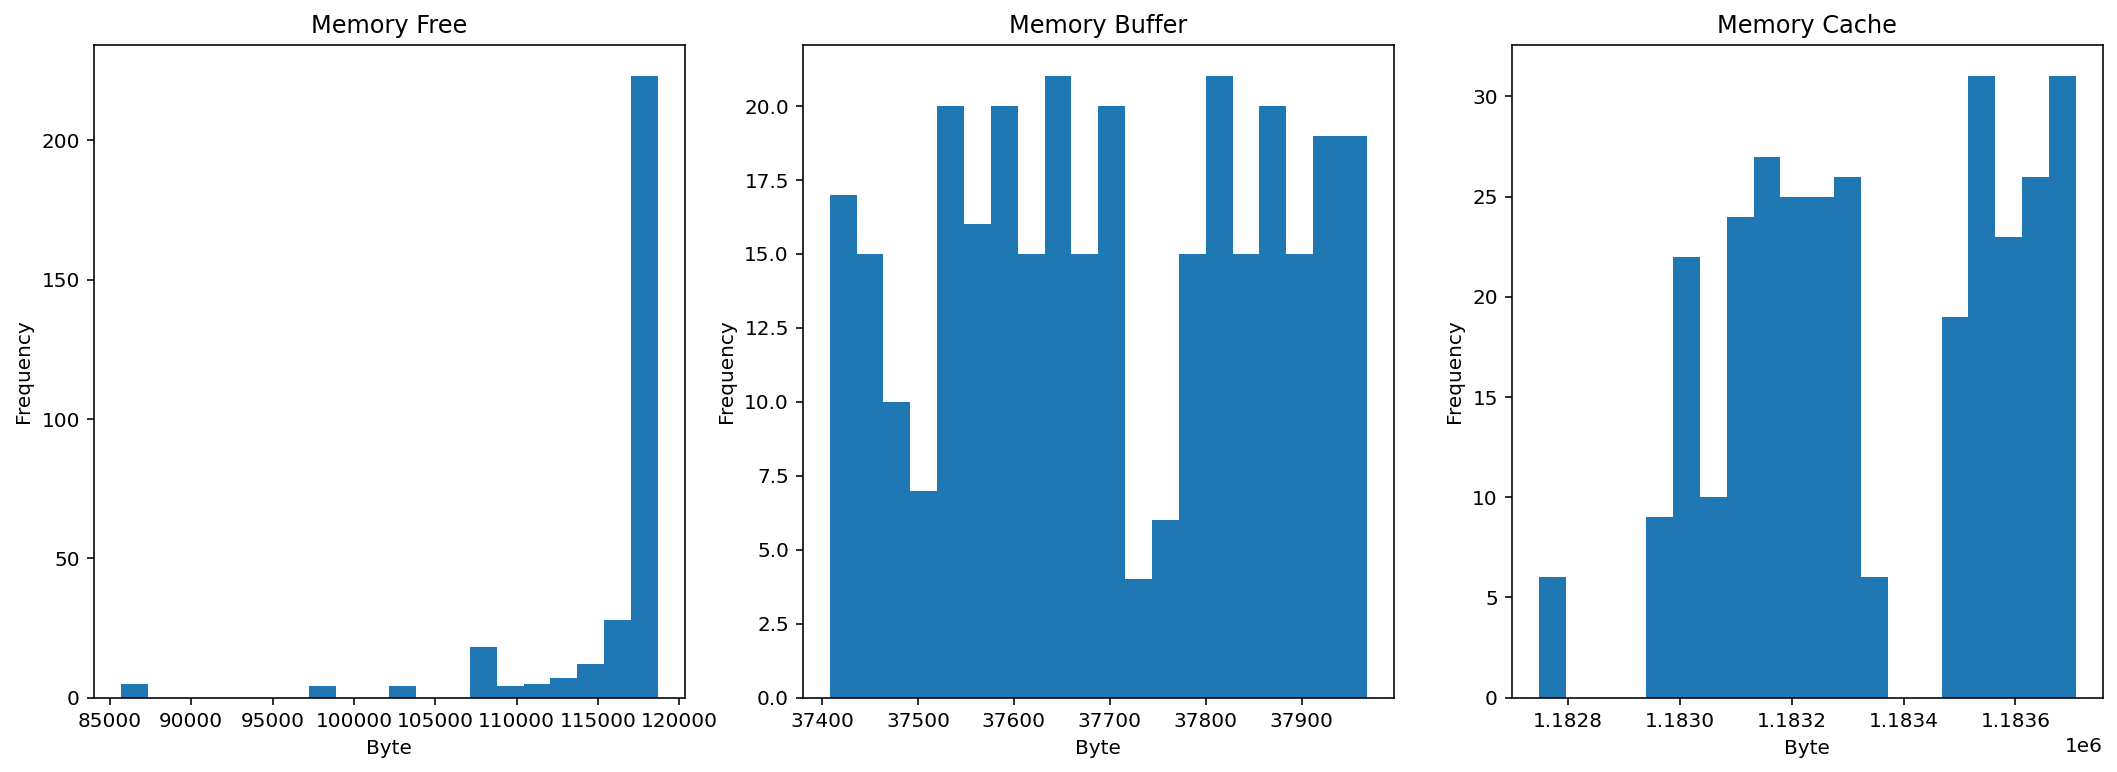

In [76]:
fig = plt.figure(figsize=(18,6))

ax0 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)

df_low.memory_free.plot.hist(bins=20, ax=ax0)
df_low.memory_buff.plot.hist(bins=20, ax=ax1)
df_low.memory_cache.plot.hist(bins=20, ax=ax2)

ax0.set_title('Memory Free')
ax0.set_xlabel('Byte')
# ax0.set_xticks(np.arange(0, max(df_high.elapsed), 5))

ax1.set_title('Memory Buffer')
ax1.set_xlabel('Byte')
# ax1.set_xticks(np.arange(0, max(df_high.Latency), 5))

ax2.set_title('Memory Cache')
ax2.set_xlabel('Byte')

plt.savefig("./images/Esercizio3_WC_LL_Synth_Mem.svg", format = "svg")
plt.show()

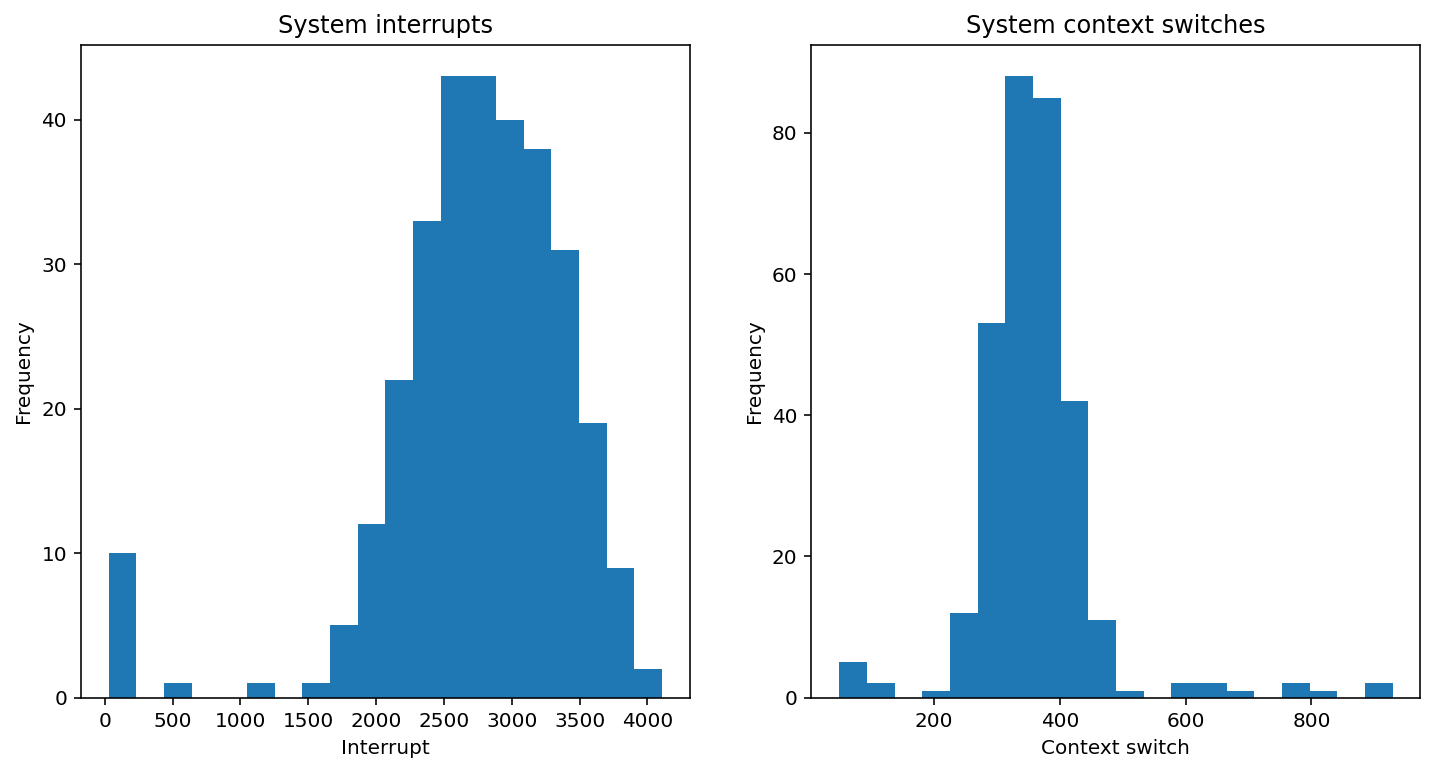

In [77]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_low.system_in.plot.hist(bins=20, ax=ax0)
df_low.system_cs.plot.hist(bins=20, ax=ax1)

ax0.set_title('System interrupts')
ax0.set_xlabel('Interrupt')

ax1.set_title('System context switches')
ax1.set_xlabel('Context switch')
plt.savefig("./images/Esercizio3_WC_LL_Synth_Int.svg", format = "svg")
plt.show()

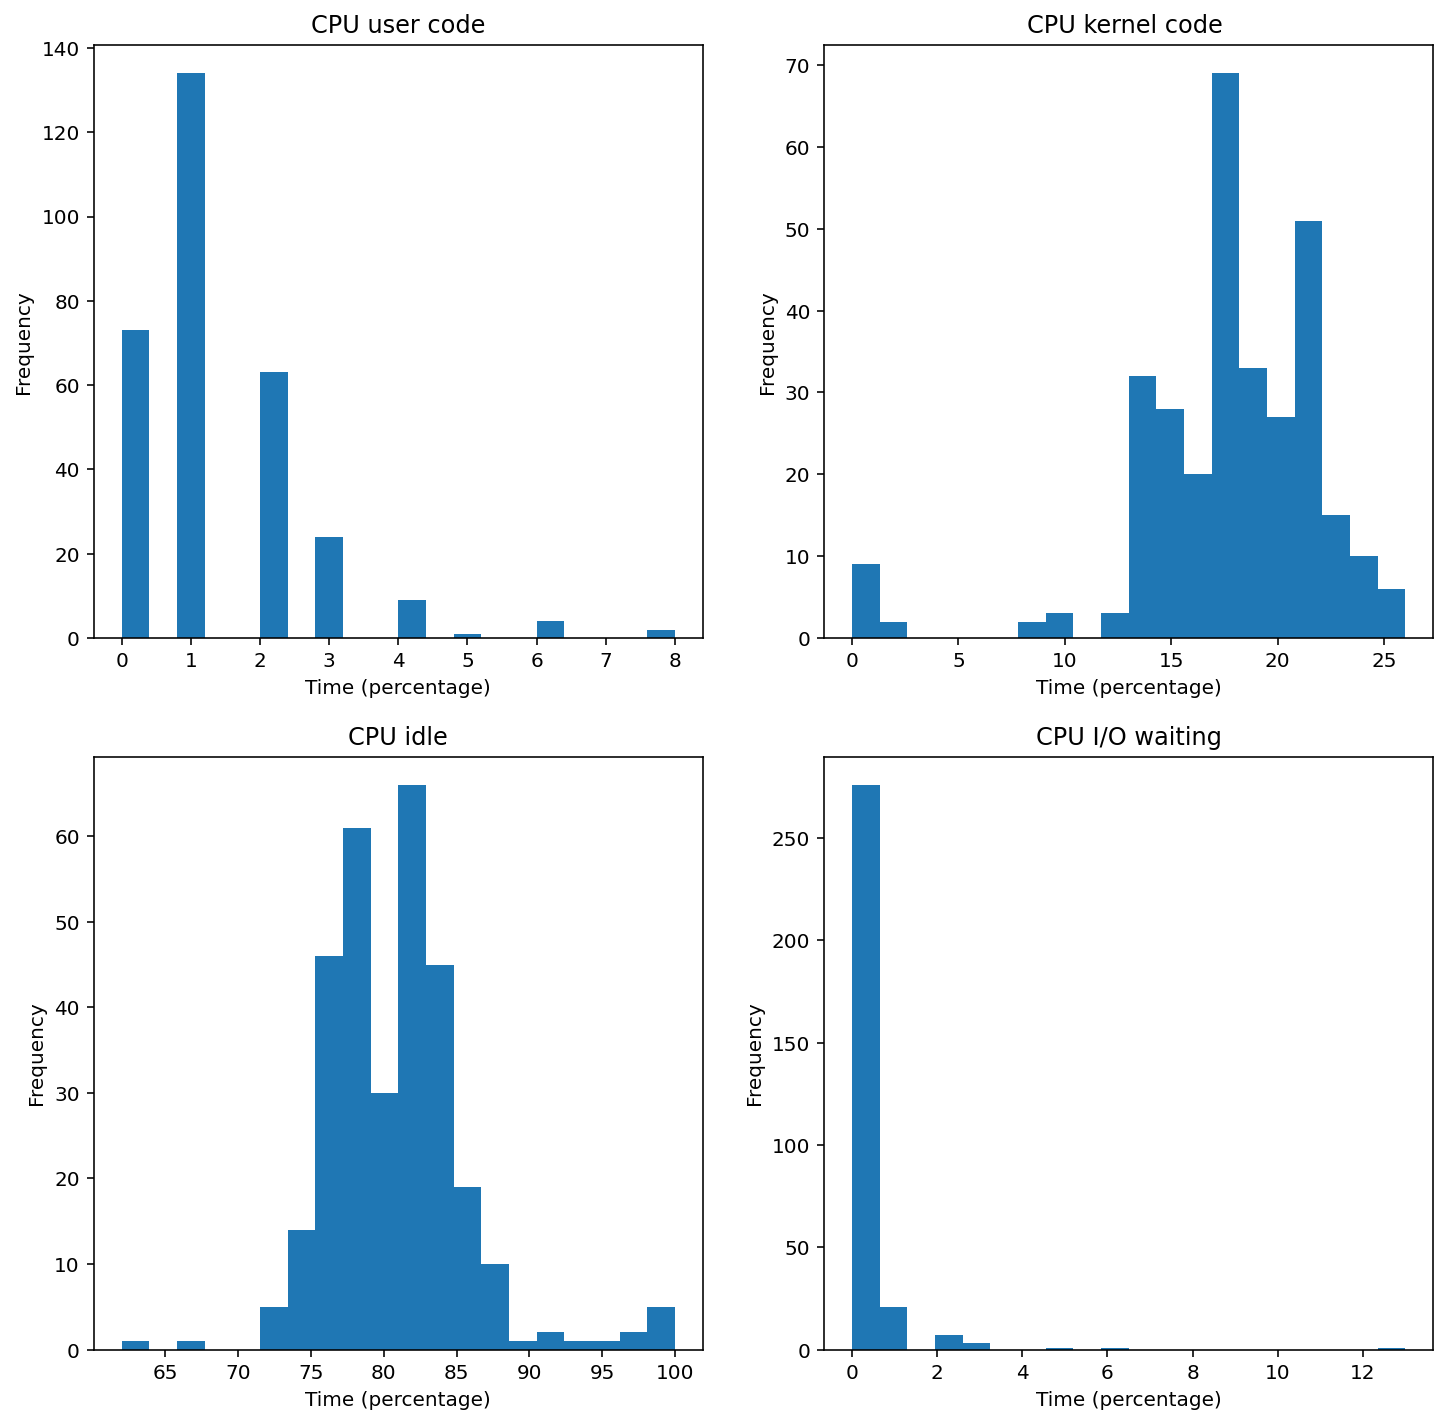

In [78]:
fig = plt.figure(figsize=(12,12))

ax0 = fig.add_subplot(2,2,1)
ax1 = fig.add_subplot(2,2,2)
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)

df_low.cpu_us.plot.hist(bins=20, ax=ax0)
df_low.cpu_sy.plot.hist(bins=20, ax=ax1)
df_low.cpu_id.plot.hist(bins=20, ax=ax2)
df_low.cpu_wa.plot.hist(bins=20, ax=ax3)

ax0.set_title('CPU user code')
ax0.set_xlabel('Time (percentage)')

ax1.set_title('CPU kernel code ')
ax1.set_xlabel('Time (percentage)')

ax2.set_title('CPU idle')
ax2.set_xlabel('Time (percentage)')

ax3.set_title('CPU I/O waiting')
ax3.set_xlabel('Time (percentage)')

plt.savefig("./images/Esercizio3_WC_LL_Synth_CPU.svg", format = "svg")

plt.show()

## PCA

### Preprocessing

#### Remove constant components

In [79]:
df_const = df_low.loc[:,df_low.columns[df_low.nunique() == 1]]
df_const.head()

,memory_swpd,cpu_st
0,14168,0
1,14168,0
2,14168,0
3,14168,0
4,14168,0


In [80]:
df_low_pre = df_low.loc[:,df_low.columns[df_low.nunique() != 1]]
df_low_pre.head()

,procs_r,procs_b,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa
0,3,0,85676,37408,1182752,0,2,239,203,205,256,3,2,94,2
1,0,1,85668,37416,1182756,0,0,0,52,108,455,8,1,91,0
2,0,0,85668,37416,1182756,0,0,0,0,67,191,3,0,91,6
3,1,0,85668,37416,1182756,0,0,0,0,42,83,0,0,100,0
4,0,0,85668,37416,1182756,0,0,0,0,37,102,1,0,99,0


#### Remove perfectly correlated components

In [82]:
df_corr = df_low_pre.corr()
df_corr

,procs_r,procs_b,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa
procs_r,1.000000,-0.039303,-0.179342,0.439898,0.422205,-0.022618,0.115769,0.054726,-0.035635,0.029744,-0.041551,-0.100628,0.049385,-0.008103,-0.025217
procs_b,-0.039303,1.000000,-0.246629,-0.064034,-0.083245,-0.005624,-0.005624,0.356965,0.023155,-0.233886,-0.068076,0.130760,-0.248529,0.192601,0.079637
memory_free,-0.179342,-0.246629,1.000000,0.100589,0.133957,-0.180685,-0.314031,-0.337459,-0.216505,0.356635,0.011869,-0.143981,0.313050,-0.198602,-0.342693
memory_buff,0.439898,-0.064034,0.100589,1.000000,0.990040,0.016647,-0.099571,-0.121501,-0.100229,0.131382,-0.001050,-0.102590,0.091360,-0.051832,-0.057953
memory_cache,0.422205,-0.083245,0.133957,0.990040,1.000000,0.039163,-0.136217,-0.129785,-0.085325,0.189967,0.029891,-0.112358,0.150998,-0.108993,-0.056518
swap_si,-0.022618,-0.005624,-0.180685,0.016647,0.039163,1.000000,-0.003236,0.389982,0.026085,-0.041331,0.334923,0.210612,0.028969,-0.105564,0.104537
swap_so,0.115769,-0.005624,-0.314031,-0.099571,-0.136217,-0.003236,1.000000,0.669640,0.137240,-0.204466,-0.061182,0.075250,-0.192164,0.158927,0.104537
io_bi,0.054726,0.356965,-0.337459,-0.121501,-0.129785,0.389982,0.669640,1.000000,0.111663,-0.268856,0.002076,0.095749,-0.239100,0.173159,0.214519
io_bo,-0.035635,0.023155,-0.216505,-0.100229,-0.085325,0.026085,0.137240,0.111663,1.000000,-0.010460,0.054393,0.000922,-0.009747,-0.097305,0.524656
system_in,0.029744,-0.233886,0.356635,0.131382,0.189967,-0.041331,-0.204466,-0.268856,-0.010460,1.000000,0.423867,-0.060973,0.922528,-0.863704,-0.126694


In [83]:
# mask = np.ones(df_corr.shape, dtype='bool')
# mask[np.triu_indices(len(df_corr))] = False

# corr_comp = (df_corr == 1 & mask).values.nonzero()
# corr_comp = [val[0] for val in corr_comp]

# df_low_pre.columns[corr_comp]

In [84]:
# df_low_pre = df_low_pre.drop(df_low_pre.columns[corr_comp[0]], axis=1)
# df_low_pre.head()

#### Normalize the components

In [85]:
x = df_low_pre.values

x_scaled = StandardScaler().fit_transform(x)

df_low_pre = pd.DataFrame(data=x_scaled, columns=df_low_pre.columns )
df_low_pre.head()

,procs_r,procs_b,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa
0,2.035032,-0.098853,-5.520153,-1.750297,-2.394483,-0.056888,17.578396,11.771192,2.412457,-3.594178,-1.075484,1.322770,-3.377926,2.793685,1.837592
1,-0.397590,10.115994,-5.521610,-1.701656,-2.378084,-0.056888,-0.056888,-0.096589,0.458532,-3.731746,0.986443,5.288521,-3.593880,2.159686,-0.226370
2,-0.397590,-0.098853,-5.521610,-1.701656,-2.378084,-0.056888,-0.056888,-0.096589,-0.214343,-3.789893,-1.748978,1.322770,-3.809833,2.159686,5.965517
3,0.413284,-0.098853,-5.521610,-1.701656,-2.378084,-0.056888,-0.056888,-0.096589,-0.214343,-3.825349,-2.868013,-1.056681,-3.809833,4.061683,-0.226370
4,-0.397590,-0.098853,-5.521610,-1.701656,-2.378084,-0.056888,-0.056888,-0.096589,-0.214343,-3.832440,-2.671146,-0.263531,-3.809833,3.850350,-0.226370


### Perform PCA

In [87]:
pca = PCA()

princ_comp = pca.fit(df_low_pre.values)

In [88]:
d = pca.transform(df_low_pre.values)

c = [str(s) for s in range(princ_comp.n_components_)]
c = ['comp ' + s for s in c]

df_low_pca = pd.DataFrame(data=d, columns=c)
df_low_pca.head()

,comp 0,comp 1,comp 2,comp 3,comp 4,comp 5,comp 6,comp 7,comp 8,comp 9,comp 10,comp 11,comp 12,comp 13,comp 14
0,14.004668,7.924006,7.959925,1.522745,12.877714,-2.016745,-4.080613,4.608340,-0.870372,0.866465,0.061711,-1.142733,-0.109726,-0.005544,0.000110
1,8.229493,4.007919,0.608462,-4.257872,-4.989456,7.494731,-2.601504,-1.511154,0.536312,2.264099,-0.582901,-2.020964,0.008391,0.111898,-0.017025
2,7.693504,2.320524,0.307131,2.252385,-3.752931,-1.274410,-1.733064,-2.608520,-3.701884,-2.014364,-0.254017,-0.033356,-0.209735,0.276488,-0.022609
3,8.178028,-1.360285,-1.014355,0.556609,-0.745953,-1.014638,-1.065217,-4.070615,-1.331904,1.663895,-0.284857,0.488313,-0.110519,0.292435,0.022498
4,8.070058,-0.811502,-1.265710,0.141873,-1.165648,-1.083670,-1.200077,-3.470965,-1.670239,1.896610,-0.564164,0.574383,-0.014641,0.298743,0.011983


#### Explained variance

In [89]:
d = {'explained variance': princ_comp.explained_variance_, 'explained variance ratio': princ_comp.explained_variance_ratio_}

df_variance_PCA = pd.DataFrame(data=d)

df_variance_PCA['cumulative explained variance ratio'] = df_variance_PCA.cumsum()['explained variance ratio']
df_variance_PCA

,explained variance,explained variance ratio,cumulative explained variance ratio
0,3.694402,0.245499,0.245499
1,2.503677,0.166373,0.411872
2,2.125854,0.141266,0.553139
3,1.421756,0.094478,0.647617
4,1.241644,0.082509,0.730126
5,0.950679,0.063174,0.793300
6,0.890531,0.059177,0.852477
7,0.765399,0.050862,0.903339
8,0.498200,0.033106,0.936446
9,0.454847,0.030225,0.966671


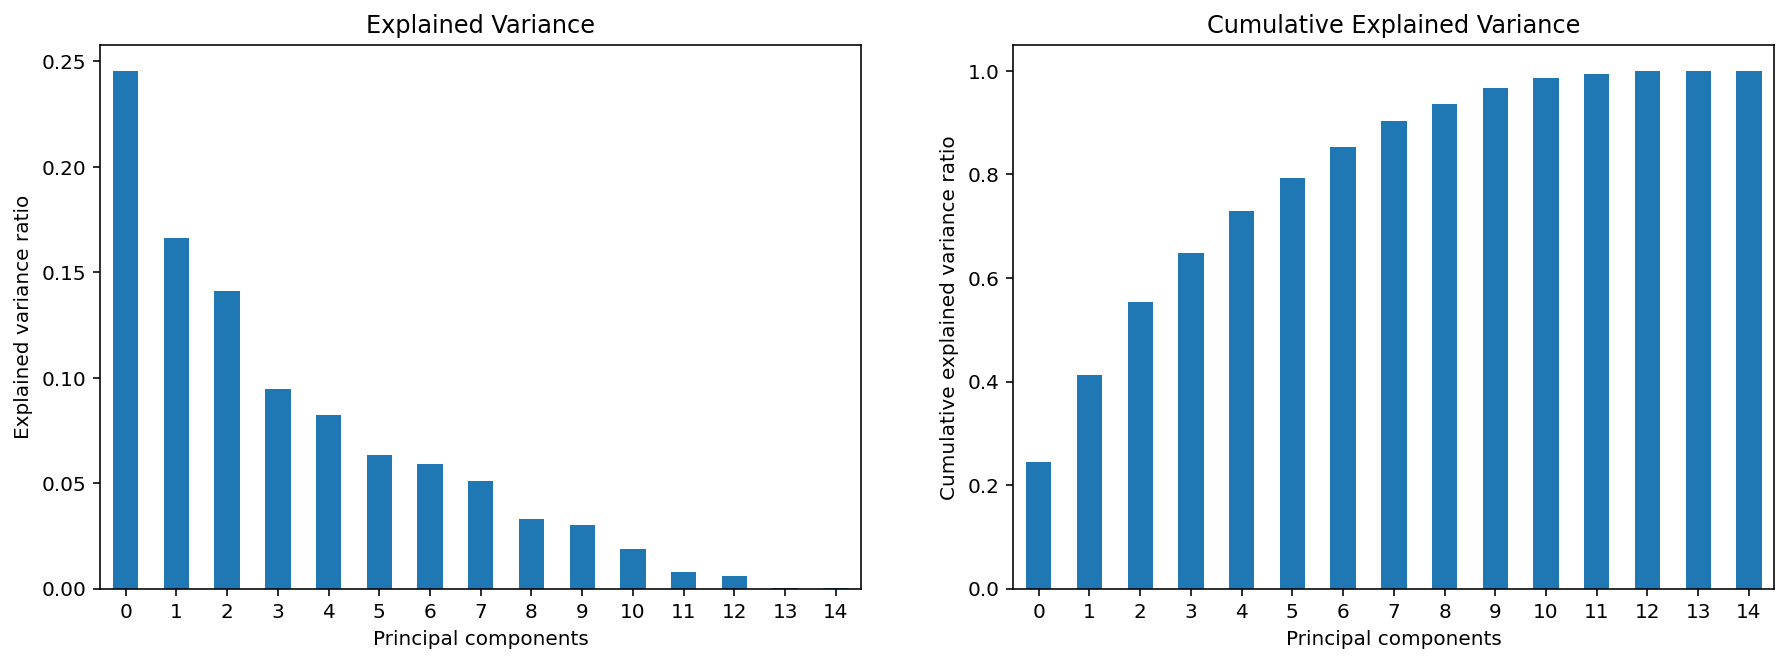

In [90]:
fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

df_variance_PCA.plot.bar(y=['explained variance ratio'], ax=ax0, legend=False)
df_variance_PCA.plot.bar(y=['cumulative explained variance ratio'], ax=ax1, legend=False)

ax0.tick_params(labelrotation=0)
ax0.set_title('Explained Variance')
ax0.set_xlabel('Principal components')
ax0.set_ylabel('Explained variance ratio')

ax1.tick_params(labelrotation=0)
ax1.set_title('Cumulative Explained Variance')
ax1.set_xlabel('Principal components')
ax1.set_ylabel('Cumulative explained variance ratio')
plt.savefig("./images/Esercizio3_WC_LL_Synth_PCA.svg", format = "svg")

plt.show()

## Clustering

### Select principal components

In [104]:
dev_tot = df_low_pre.sub(df_low_pre.mean()).pow(2).sum().sum()

nmin_comp = 4
nmax_comp = 8
n_comp = nmax_comp-nmin_comp+1

nmax_cluster = 50

array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
filepath = './array_dev_lost_low_synth.txt'
if(not os.path.isfile(filepath)):
    print('Creating file',filepath, 'this may take a while...\n')
    
    array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
    
    for i in tqdmn(range(nmin_comp, nmax_comp+1), desc='outer loop'):

        for j in tqdmn(range(1, nmax_cluster+1), desc='inner loop'):
            df_clustering = df_low_pca.iloc[:,0:i]

            # clustering
            clustering = AgglomerativeClustering(n_clusters=j)
            clustering = clustering.fit(df_clustering.values)

            df_clustering.insert(len(df_clustering.columns), 'cluster', clustering.labels_)

            # deviance PCA
            df_pca = df_low_pca.iloc[:,0:i]
            dev_pca = df_pca.sub(df_pca.mean()).pow(2).sum().sum()

            # deviance clustering 
            n_elem = df_clustering.groupby('cluster').count().values[:,0]
            centroids = df_clustering.groupby('cluster').mean()

            # intra-cluster deviance
            arr = np.zeros(shape=(j,1))
            for k in range(j):
                elem_k = df_clustering.loc[df_clustering['cluster'] == k].drop(columns='cluster')
                arr[k] = elem_k.sub(centroids.loc[k,:]).pow(2).sum().sum()
            dev_intra = arr.sum()

            # inter-cluster deviance
            dev_inter = centroids.sub(df_clustering.mean()).pow(2).mul(n_elem, axis=0).sum().sum()
            dev_inter

            # deviance lost
            dev_pca_ratio = dev_pca/dev_tot
            dev_inter_ratio = dev_inter/dev_pca
            dev_lost = 1 - dev_inter_ratio * dev_pca_ratio

            array_dev_lost[j-1][i-n_comp+1] = dev_lost

#             print(array_dev_lost)
    with open (filepath, 'wb') as fp:
        pickle.dump(array_dev_lost, fp)

else:
    print('File already exists!\n')
    with open (filepath, 'rb') as fp:
        array_dev_lost = pickle.load(fp)
        
        
# array_dev_lost

Creating file ./array_dev_lost_low_synth.txt this may take a while...



In [105]:
array_dev_lost

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.8601664 , 0.85355147, 0.85445508, 0.85322387, 0.85296059],
       [0.75876183, 0.75496742, 0.75120149, 0.75168596, 0.75117095],
       [0.67411503, 0.66603295, 0.65175708, 0.65592114, 0.65587197],
       [0.61641076, 0.58966453, 0.57487188, 0.57887935, 0.57329837],
       [0.5727548 , 0.53618744, 0.51639693, 0.50391093, 0.49586682],
       [0.54104476, 0.49173547, 0.46108104, 0.44383479, 0.43534061],
       [0.51859541, 0.46846252, 0.41908916, 0.39541705, 0.39932079],
       [0.49974328, 0.44601001, 0.39747216, 0.37230559, 0.36517685],
       [0.48432898, 0.42773804, 0.37822731, 0.35331361, 0.33983034],
       [0.47324562, 0.41685377, 0.36534258, 0.33826184, 0.31735376],
       [0.4635249 , 0.40663427, 0.35408717, 0.32335554, 0.29774793],
       [0.45505087, 0.39691217, 0.34362084, 0.30931837, 0.28328984],
       [0.44698165, 0.38724568, 0.33323399, 0.29679529, 0.26897837],
       [0.43982879, 0.37844304, 0.

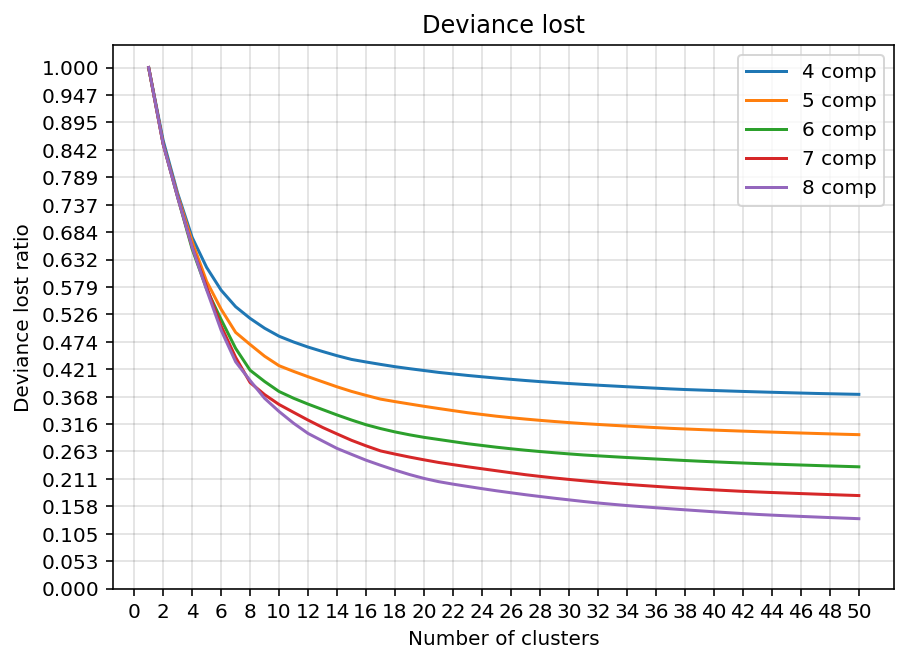

In [107]:
x = np.arange(1,nmax_cluster+1)

plt.figure(figsize=(7,5))

for i in range(nmin_comp,nmax_comp+1):
    y_dev_lost = array_dev_lost[:,i-n_comp+1]
    plt.plot(x, y_dev_lost)
    
c = [str(s) for s in range(nmin_comp,nmax_comp+1)]
c = [s + ' comp' for s in c]
    
plt.title('Deviance lost')
plt.ylabel('Deviance lost ratio')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(0,nmax_cluster+1,2))
plt.yticks(np.linspace(0,y_dev_lost.max(),20))
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(c)
plt.savefig("./images/Esercizio3_WC_LL_Synth_Tradeoff.svg", format = "svg")
plt.show()

In [93]:
n_comp = 8
df_low_cl = df_low_pca.iloc[:,0:n_comp]
df_low_cl.head()

,comp 0,comp 1,comp 2,comp 3,comp 4,comp 5,comp 6,comp 7
0,14.004668,7.924006,7.959925,1.522745,12.877714,-2.016745,-4.080613,4.608340
1,8.229493,4.007919,0.608462,-4.257872,-4.989456,7.494731,-2.601504,-1.511154
2,7.693504,2.320524,0.307131,2.252385,-3.752931,-1.274410,-1.733064,-2.608520
3,8.178028,-1.360285,-1.014355,0.556609,-0.745953,-1.014638,-1.065217,-4.070615
4,8.070058,-0.811502,-1.265710,0.141873,-1.165648,-1.083670,-1.200077,-3.470965


### Perform clustering

In [94]:
n_clusters = 20

clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering = clustering.fit(df_low_cl.values)

In [95]:
df_low_clustered = df_low
df_low_clustered.loc[:,'cluster'] = clustering.labels_
df_low_clustered.head()

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st,cluster
0,3,0,14168,85676,37408,1182752,0,2,239,203,205,256,3,2,94,2,0,19
1,0,1,14168,85668,37416,1182756,0,0,0,52,108,455,8,1,91,0,0,15
2,0,0,14168,85668,37416,1182756,0,0,0,0,67,191,3,0,91,6,0,13
3,1,0,14168,85668,37416,1182756,0,0,0,0,42,83,0,0,100,0,0,13
4,0,0,14168,85668,37416,1182756,0,0,0,0,37,102,1,0,99,0,0,13


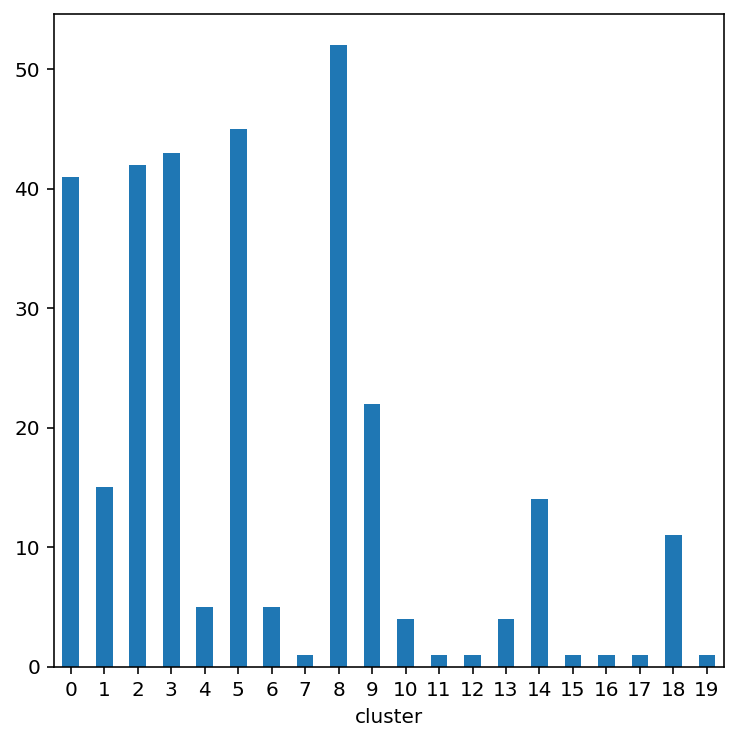

In [96]:
df_low_clustered.groupby(by='cluster').count().procs_r.plot.bar(figsize=(6,6))
plt.xticks(rotation=0)
plt.savefig("./images/Esercizio3_WC_LL_Synth_Clu.svg", format = "svg")

plt.show()

In [97]:
df_low_pca.loc[:,'cluster'] = clustering.labels_
df_low_pca

,comp 0,comp 1,comp 2,comp 3,comp 4,comp 5,comp 6,comp 7,comp 8,comp 9,comp 10,comp 11,comp 12,comp 13,comp 14,cluster
0,14.004668,7.924006,7.959925,1.522745,12.877714,-2.016745,-4.080613,4.608340,-0.870372,0.866465,0.061711,-1.142733,-0.109726,-0.005544,0.000110,19
1,8.229493,4.007919,0.608462,-4.257872,-4.989456,7.494731,-2.601504,-1.511154,0.536312,2.264099,-0.582901,-2.020964,0.008391,0.111898,-0.017025,15
2,7.693504,2.320524,0.307131,2.252385,-3.752931,-1.274410,-1.733064,-2.608520,-3.701884,-2.014364,-0.254017,-0.033356,-0.209735,0.276488,-0.022609,13
3,8.178028,-1.360285,-1.014355,0.556609,-0.745953,-1.014638,-1.065217,-4.070615,-1.331904,1.663895,-0.284857,0.488313,-0.110519,0.292435,0.022498,13
4,8.070058,-0.811502,-1.265710,0.141873,-1.165648,-1.083670,-1.200077,-3.470965,-1.670239,1.896610,-0.564164,0.574383,-0.014641,0.298743,0.011983,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,-0.585817,-1.636118,1.417831,-0.128354,-0.158116,-0.061529,0.238243,0.569340,-0.155753,0.088341,-0.107891,-0.044327,0.317256,0.048287,-0.002275,5
306,5.456134,-4.970965,0.580834,-0.244897,-1.463838,-1.509407,1.044801,1.265106,0.050922,0.079162,-0.160429,-0.156739,0.234968,-0.088551,0.003870,10
307,5.395954,-4.267319,0.921004,0.061978,-2.093213,-1.553562,0.740208,1.584466,-0.169927,-0.562212,-0.545206,-0.214589,0.304030,-0.056265,-0.001322,10
308,5.278752,-4.539084,0.716938,-0.650855,-1.774081,-1.547908,0.603746,1.484243,0.123133,0.037784,-0.326919,-0.091366,0.305916,-0.055990,-0.000984,10


In [98]:
# pd.set_option('display.max_rows', 50)
# df_low_clustered.groupby(by='cluster').mean().plot(kind='bar', subplots=True, figsize=(12,30), legend=False)
# sns.barplot(x='cluster', columns=df_low_clu.columns, data=df_low_clu)
# plt.show()

## Synthetic workload

In [99]:
df_synth_synth = df_low_pca.groupby('cluster').apply(lambda x: x.sample())
df_synth_synth = df_synth_synth.reset_index(level=0, col_level=2 , drop=True)
df_synth_synth

,comp 0,comp 1,comp 2,comp 3,comp 4,comp 5,comp 6,comp 7,comp 8,comp 9,comp 10,comp 11,comp 12,comp 13,comp 14,cluster
165,-0.528648,0.516447,-0.333418,-0.685251,-0.363555,-0.084958,-0.507691,0.707925,0.138647,-0.089947,-0.634834,0.105741,0.012376,0.092891,-0.007087,0
270,-0.537519,-1.384047,2.853842,-0.298491,0.086719,0.113961,-1.608299,-1.396146,1.253289,-0.769207,-0.154771,0.115507,-0.150175,-0.032362,0.007725,1
76,-0.213068,0.402033,-1.239960,-0.006969,0.439171,0.000799,0.189593,-0.127725,0.106850,-0.241390,0.094611,-0.162926,0.518971,-0.001442,-0.002086,2
160,1.316680,-1.084521,-0.630928,0.645981,-0.070127,-0.425409,0.769324,0.318614,0.543347,0.338973,0.289442,-0.089462,-0.000465,0.071869,0.009577,3
232,-1.904465,1.886734,1.432900,-1.387383,-1.625379,-0.412077,-1.037651,1.249162,-0.122444,0.196861,2.739930,0.154933,-0.287989,-0.013786,-0.051656,4
304,-1.317862,-1.028790,1.155085,-0.275655,-0.184348,0.041178,0.432867,0.962134,-0.555259,0.578448,0.290108,0.155717,-0.661205,0.076906,-0.007771,5
8,2.778825,2.325714,-0.888352,-2.478314,-2.036891,-1.097664,-2.546268,-0.351124,0.424746,0.518889,1.457258,0.455367,0.082404,-0.217565,-0.054124,6
180,0.427197,11.499850,8.650704,-8.340915,-1.350201,-6.152063,9.438576,-3.801667,1.174832,0.045734,-1.028563,-0.703054,-0.138270,-0.000032,0.000081,7
129,-1.487759,1.116385,-0.585211,-0.135509,0.169148,0.180591,-0.180242,0.348542,0.254379,0.160060,-0.041480,0.107712,-0.314371,0.085772,-0.004332,8
143,-0.633081,0.330401,0.152674,-0.597848,0.052635,0.053213,-1.090683,-0.230854,0.863821,-0.833504,-0.735997,0.001504,0.233780,0.067628,0.003161,9


In [100]:
df_synth_synth.to_csv('df_synth_synth.csv', index=False)

# Hypothesis test

In [101]:
df_synth_real.reset_index(inplace=True, drop=True)
df_synth_synth.reset_index(inplace=True, drop=True)

df_synth_sub = df_synth_real.sub(df_synth_synth)
df_synth_sub

,comp 0,comp 1,comp 2,comp 3,comp 4,comp 5,comp 6,comp 7,comp 8,comp 9,comp 10,comp 11,comp 12,comp 13,comp 14,cluster
0,1.635795,-2.709162,1.431560,2.719394,1.430089,5.810328,0.235633,-0.598439,-0.455747,0.028708,0.679020,-0.195239,0.044364,-0.086311,0.007087,0
1,-0.247324,2.149937,-0.784946,-0.057379,-0.371752,-0.298006,1.678798,1.164899,-1.291599,0.686377,-0.084848,-0.071900,0.080868,0.029257,-0.007725,0
2,0.176092,0.512771,-0.267804,0.624174,-0.037475,1.470735,-0.363894,0.287178,0.132193,0.163808,0.111233,0.149731,-0.503379,0.003711,0.002086,0
3,-1.355851,0.974796,-1.689827,-0.682299,-0.107941,0.090740,-0.794134,-0.156022,-0.798234,-0.435888,-0.173206,0.130367,0.055963,-0.076206,-0.009577,0
4,1.522315,-1.838999,0.531992,0.995409,1.088596,0.154966,1.264412,-1.827029,-0.354645,-0.115845,-3.083648,-0.089560,0.180761,0.007005,0.051656,0
5,0.820885,2.642728,-1.961788,0.321374,0.142619,-0.437302,-0.111323,-0.826256,0.409580,-0.686801,-0.452463,-0.120347,0.594393,-0.077681,0.007771,0
6,-4.037170,1.853809,4.658476,2.181712,3.989355,-0.122935,1.267904,-0.256700,-1.086499,-0.251261,-1.581155,-0.808670,-0.135760,0.208849,0.054124,0
7,0.121200,-10.358129,-9.947171,8.701637,3.436869,4.820481,-9.955337,3.587795,-1.848289,0.276230,1.207494,0.277362,0.209268,-0.018254,-0.000081,0
8,1.576132,-3.697493,0.845105,-0.311985,-0.636109,-0.179760,-0.071039,-0.489321,-0.180135,-0.235705,0.364717,-0.100588,0.319244,-0.096021,0.004332,0
9,0.073931,-0.061400,-1.641284,0.495261,-0.088891,-0.177752,0.716739,0.778117,-0.922329,0.593407,1.034636,0.023818,-0.288137,-0.066367,-0.003161,0


In [102]:
df_synth_sub.drop('cluster', axis=1).to_csv('df_synth_sub.csv', index=False)